# Lecture 16 - Reinforcement Learning

```{contents}
:local:
:depth: 1
```

## Learning goals


- Understand the definition of agent, environment, state, action, reward, trajectory, policy, and value.
- Build a tiny grid world with a chemistry flavor and implement tabular Q-learning step by step.
- Compare exploration strategies such as epsilon greedy, optimistic starts, UCB1, and Thompson sampling in bandits.
- Practice a simplified policy gradient on a bandit.
[![Colab](https://img.shields.io/badge/Open-Colab-orange)](https://colab.research.google.com/drive/1dLok-Ve2VyvyKwLRY-08n-MCCKd88XiN?usp=sharing)


## 0. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable, Optional
from matplotlib.patches import Circle, FancyBboxPatch
from matplotlib.patheffects import withStroke

np.random.seed(42)
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = False

## 1. Reinforcement learning concepts
Reinforcement learning studies decision making through repeated interaction.

An agent observes a state $s$, chooses an action $a$, gets a reward $r$, and moves to a new state $s'$.

The aim is to maximize expected return $G = r_0 + \gamma r_1 + \gamma^2 r_2 + \cdots$ with $\gamma \in [0,1)$.

For example, in closed-loop chemistry discovery the agent proposes the next experiment and the environment is the lab system that reports outcomes like yield.

Here are key terms:
- **State $s$**: summary of what matters right now.
- **Action $a$**: a choice such as a set of synthesis conditions.
- **Reward $r$**: scalar signal such as yield or a utility of yield and purity.
- **Policy $\pi(a\mid s)$**: a rule to pick actions given a state.
- **Value $V^{\pi}(s)$**: expected return from state $s$ under policy $\pi$.
- **Action value $Q^{\pi}(s,a)$**: expected return if we choose $a$ in $s$ then follow $\pi$.
- **Model**: transition and reward dynamics, often unknown in labs.

The next plot shows this loop visually.

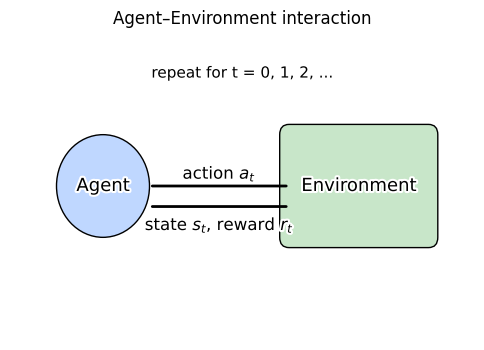

In [2]:
def _outlined_text(ax, x, y, s, ha="center", va="center", size=12):
    pe = [withStroke(linewidth=3, foreground="white")]
    ax.text(x, y, s, ha=ha, va=va, fontsize=size, path_effects=pe)

def draw_agent_environment_diagram():
    fig, ax = plt.subplots()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 6)
    ax.axis("off")

    # Agent (circle)
    agent = Circle((2.0, 3.0), radius=1.0, facecolor="#bfd7ff", edgecolor="black")
    ax.add_patch(agent)
    _outlined_text(ax, 2.0, 3.0, "Agent", size=13)

    # Environment (rounded rectangle)
    env = FancyBboxPatch(
        (6.0, 2.0), 3.0, 2.0,
        boxstyle="round,pad=0.2,rounding_size=0.2",
        facecolor="#c8e6c9", edgecolor="black"
    )
    ax.add_patch(env)
    _outlined_text(ax, 7.5, 3.0, "Environment", size=13)

    # Arrows: action (Agent -> Env), observation+reward (Env -> Agent)
    ax.annotate(
        "", xy=(6.0, 3.0), xytext=(3.0, 3.0),
        arrowprops=dict(arrowstyle="-", lw=2)
    )
    _outlined_text(ax, 4.5, 3.25, r"action $a_t$")

    ax.annotate(
        "", xy=(3.0, 2.6), xytext=(6.0, 2.6),
        arrowprops=dict(arrowstyle="-", lw=2)
    )
    _outlined_text(ax, 4.5, 2.25, r"state $s_t$, reward $r_t$")

    # Timeline hint
    _outlined_text(ax, 5.0, 5.2, "repeat for t = 0, 1, 2, ...", size=11)

    plt.title("Agent–Environment interaction")
    plt.show()

draw_agent_environment_diagram()


## 2. Let's play games to understand Q-Learning!

One of the simplest ways of doing Reinforcement Learning is called Q-learning. Here we want to estimate so-called **Q-values** which are also called action-values, because they map a state of the game-environment to a numerical value for *each possible action that the agent may take*. The Q-values indicate which action is expected to result in the highest **future reward**, thus telling the agent which action to take.

$$
    Q(s_{t},a_{t}) \leftarrow \underbrace{r_{t}}_{\rm reward} + \underbrace{\gamma}_{\rm discount} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\rm estimate~of~future~rewards}
$$

Most of time, we do not know what the Q-values are supposed to be, so we first initialize all to zero and then updated repeatedly as new information is collected from the agent playing the game. When update the Q-valu, we consider **discount-factor** slightly below 1, which this causes more distant rewards (e.g. take 10 steps to get 1 point vs. take 2 step to get 1 point) to contribute less to the Q-value, thus making the agent favour rewards that are closer in time.

Therefore, the formula for updating the Q-value is:

> Q-value for state and action = reward + discount * max Q-value for next state


Next, we’ll play interactive “games” that make these updates visible.



### 2.1 Interactive Game 1 — Breakout

**State**

Binned ball and paddle positions plus ball velocity signs.

**Actions**

Left, Stay, Right.

**Controls**
- ← / → or A / D to move the paddle.
- Try manual mode first.
- Enable **Agent** in the panel to let Q-learning play automatically.
- Adjust:
  - ε (epsilon): exploration rate  
  - α (alpha): learning rate  
  - γ (gamma): discount factor

**Rewards**
- +1 for breaking a brick  
- +0.01 for hitting the ball with the paddle  
- −1 for losing a life  
- −0.001 per step to encourage faster play

Try training for several episodes and then watch the agent’s learned behavior.

In [3]:
from IPython.display import HTML

HTML(r"""
<div id="breakout-container" style="font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial; margin: 1rem 0;">
  <div style="display:flex;flex-wrap:wrap;align-items:center;gap:.5rem;margin-bottom:.5rem;">
    <button id="bo-start" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Start</button>
    <button id="bo-pause" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Pause</button>
    <button id="bo-reset" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset</button>
    <label style="margin-left:1rem;display:flex;align-items:center;gap:.35rem;color:#ddd;">
      <input type="checkbox" id="stopAtZero" />
      Stop at 0 lives
    </label>
    <span style="opacity:.85;">Controls: ←/→ or A/D, P pause, R reset</span>
  </div>

  <canvas id="breakout" width="800" height="560" style="max-width:100%;border-radius:12px;box-shadow:0 8px 24px rgba(0,0,0,.35);background:#0b1021;display:block;outline:none;"></canvas>

  <div id="bo-msg" style="margin-top:.5rem;color:#ddd;opacity:.9;">Click the canvas to focus.</div>

  <details style="margin-top:1rem;background:#0f1329;border:1px solid #222;border-radius:10px;padding:.75rem;color:#e6e6e6;">
    <summary style="cursor:pointer;font-weight:600;">Reinforcement Learning demo</summary>
    <div style="margin-top:.5rem;display:grid;grid-template-columns:repeat(auto-fit,minmax(220px,1fr));gap:.75rem;">
      <label style="display:flex;align-items:center;gap:.5rem;">
        <input type="checkbox" id="agentEnabled"/>
        Agent enabled
      </label>
      <label>ε (explore): <input id="eps" type="range" min="0" max="1" step="0.01" value="0.10" style="width:140px;">
        <span id="epsV">0.10</span></label>
      <label>α (learn rate): <input id="alpha" type="range" min="0" max="1" step="0.01" value="0.20" style="width:140px;">
        <span id="alphaV">0.20</span></label>
      <label>γ (discount): <input id="gamma" type="range" min="0" max="1" step="0.01" value="0.95" style="width:140px;">
        <span id="gammaV">0.95</span></label>
      <button id="train1" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 1 episode</button>
      <button id="train50" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 50 episodes</button>
      <button id="resetQ" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset Q-table</button>
    </div>
    <div style="margin-top:.5rem;font-size:.95rem;opacity:.9;line-height:1.4;">
      <strong>What it shows</strong>: The agent gets <code>+1</code> for breaking a brick, <code>+0.01</code> for paddle hits, <code>-1</code> for losing a life, and a tiny <code>-0.001</code> per step.
      <strong>State</strong>: binned ball x, paddle x, ball vx sign, ball vy sign.
      <strong>Actions</strong>: Left, Stay, Right.
      ε-greedy Q-learning: <code>Q(s,a) ← Q + α[r + γ max_a' Q(s',a') - Q]</code>.
    </div>
    <div id="rlStats" style="margin-top:.5rem;font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace;"></div>
  </details>

  <div style="margin-top:.75rem;padding-top:.5rem;border-top:1px solid #222;display:flex;align-items:center;gap:.5rem;color:#ddd;">
    <label style="display:flex;align-items:center;gap:.4rem;">
      <input type="checkbox" id="noMove"/>
      Don’t move (freeze paddle)
    </label>
    <span style="opacity:.75;">When checked, paddle stays still. Useful to show a baseline or to watch the ball.</span>
  </div>
</div>

<script>
(() => {
  const cvs = document.getElementById('breakout');
  const ctx = cvs.getContext('2d', { alpha: false });
  const startBtn = document.getElementById('bo-start');
  const pauseBtn = document.getElementById('bo-pause');
  const resetBtn = document.getElementById('bo-reset');
  const stopAtZero = document.getElementById('stopAtZero');
  const msg = document.getElementById('bo-msg');
  const noMove = document.getElementById('noMove');

  // RL controls
  const agentEnabledEl = document.getElementById('agentEnabled');
  const epsEl = document.getElementById('eps'), epsV = document.getElementById('epsV');
  const alphaEl = document.getElementById('alpha'), alphaV = document.getElementById('alphaV');
  const gammaEl = document.getElementById('gamma'), gammaV = document.getElementById('gammaV');
  const train1 = document.getElementById('train1');
  const train50 = document.getElementById('train50');
  const resetQ = document.getElementById('resetQ');
  const rlStats = document.getElementById('rlStats');

  epsEl.oninput = ()=> epsV.textContent = Number(epsEl.value).toFixed(2);
  alphaEl.oninput = ()=> alphaV.textContent = Number(alphaEl.value).toFixed(2);
  gammaEl.oninput = ()=> gammaV.textContent = Number(gammaEl.value).toFixed(2);
  epsV.textContent = Number(epsEl.value).toFixed(2);
  alphaV.textContent = Number(alphaEl.value).toFixed(2);
  gammaV.textContent = Number(gammaEl.value).toFixed(2);

  const W = cvs.width, H = cvs.height;
  const PADDLE_W = 120, PADDLE_H = 14, PADDLE_Y = H - 36, PADDLE_SPEED = 8;
  const BALL_R = 8, BASE_BALL_SPD = 5.5;
  const TOP_MARGIN = 64;
  const ROWS = 7, COLS = 12, GAP = 4, PAD = 16, BRICK_H = 22;
  const COLORS = ["#ff6b6b","#ffd93d","#6bcbef","#51cf66","#845ef7","#ffa94d","#f06595"];
  const HUD = {color:"#e6e6e6"};

  let paddle, ball, bricks, score, lives, level;
  let running = false, paused = false, rafId = null;

  // Agent control flags
  let training = false, abortAgent = false;

  const keys = {left:false, right:false};

  function clamp(v, lo, hi){ return Math.max(lo, Math.min(hi, v)); }

  function initPaddle(){
    return { x:(W-PADDLE_W)/2, y:PADDLE_Y, w:PADDLE_W, h:PADDLE_H, dx:0 };
  }

  function initBall(centerOnP=true){
    const x = centerOnP ? paddle.x + paddle.w/2 : W/2;
    const y = centerOnP ? paddle.y - BALL_R - 1 : H/2;
    const angle = (Math.random()*0.8 - 0.4);
    const speed = BASE_BALL_SPD * (1 + (level-1)*0.06);
    return { x, y, r:BALL_R, dx: speed * (Math.random()<.5?-1:1) * Math.abs(angle*1.6),
             dy: -speed * (1.1 - Math.abs(angle)) };
  }

  function makeBricks(){
    const totalGap = (COLS-1)*GAP;
    const bw = (W - 2*PAD - totalGap) / COLS;
    const arr = [];
    for(let r=0;r<ROWS;r++){
      for(let c=0;c<COLS;c++){
        const x = PAD + c*(bw + GAP);
        const y = TOP_MARGIN + r*(BRICK_H + GAP);
        const hits = 1;
        arr.push({x,y,w:bw,h:BRICK_H,color:COLORS[r%COLORS.length],hits,score:60+10*r, alive:true});
      }
    }
    return arr;
  }

  function resetGame(){
    score = 0; lives = 3; level = 1;
    paddle = initPaddle();
    bricks = makeBricks();
    ball = initBall();
    paused = false; running = false;
    msg.textContent = "Press Start or hit P to play. Click the canvas to focus.";
    draw();
  }

  function nextLevel(){
    level++;
    bricks = makeBricks();
    ball = initBall(true);
    msg.textContent = "Level " + level;
    setTimeout(()=>{ if(msg.textContent.startsWith("Level")) msg.textContent=""; }, 700);
  }

  function rectsIntersect(a, b){
    return a.x < b.x+b.w && a.x+a.w > b.x && a.y < b.y+b.h && a.y+a.h > b.y;
  }

  function drawHUD(){
    ctx.fillStyle = HUD.color;
    ctx.font = "16px ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial";
    ctx.textBaseline = "top";
    ctx.fillText(`Score: ${score}`, 10, 10);
    ctx.fillText(`Lives: ${lives}`, 10, 30);
    ctx.fillText(`Level: ${level}`, 10, 50);
    ctx.strokeStyle = "#263238";
    ctx.beginPath(); ctx.moveTo(0, TOP_MARGIN); ctx.lineTo(W, TOP_MARGIN); ctx.stroke();
  }

  function draw(){
    ctx.fillStyle = "#0b1021";
    ctx.fillRect(0,0,W,H);
    // Paddle
    ctx.fillStyle = "#e6e6e6";
    ctx.fillRect(paddle.x, paddle.y, paddle.w, paddle.h);
    // Ball
    ctx.fillStyle = "#ffdd57";
    ctx.beginPath();
    ctx.arc(ball.x, ball.y, ball.r, 0, Math.PI*2);
    ctx.fill();
    // Bricks
    for(const b of bricks){
      if(!b.alive) continue;
      ctx.fillStyle = b.color;
      ctx.fillRect(b.x, b.y, b.w, b.h);
    }
    drawHUD();
  }

  // ---------- RL bits ----------
  const A_LEFT = 0, A_STAY = 1, A_RIGHT = 2;
  const ACTIONS = [A_LEFT, A_STAY, A_RIGHT];
  let Q = new Map(); // key -> Float32Array(3)

  function qGet(key){
    if(!Q.has(key)) Q.set(key, new Float32Array(3)); // zeros
    return Q.get(key);
  }
  function argmax(arr){ let mi=0, mv=arr[0]; for(let i=1;i<arr.length;i++){ if(arr[i]>mv){mv=arr[i];mi=i;} } return mi; }

  // Discretize state
  const BX_BINS = 12, PX_BINS = 12;
  function stateKey(){
    const bx = Math.floor(clamp(ball.x,0,W-1) / (W/BX_BINS));
    const px = Math.floor(clamp(paddle.x,0,W-paddle.w) / ((W-paddle.w)/PX_BINS));
    const vx = ball.dx > 0 ? 1 : (ball.dx < 0 ? -1 : 0);
    const vy = ball.dy > 0 ? 1 : -1;
    return `${bx}|${px}|${vx}|${vy}`;
  }

  function agentAct(eps){
    if(Math.random() < eps) return ACTIONS[Math.floor(Math.random()*ACTIONS.length)];
    const q = qGet(stateKey());
    return argmax(q);
  }

  function applyAction(a){
    if(a === A_LEFT) { keys.left = true; keys.right = false; }
    else if(a === A_RIGHT) { keys.right = true; keys.left = false; }
    else { keys.left = false; keys.right = false; } // A_STAY
  }

  function stepReward({hitBrick=false, hitPaddle=false, lostLife=false}){
    let r = -0.001;
    if(hitBrick) r += 1.0;
    if(hitPaddle) r += 0.01;
    if(lostLife) r -= 1;
    return r;
  }

  let epReward = 0, epSteps = 0, episodesDone = 0;

  // Helper to stop the agent cleanly
  function stopAgent(reason = ""){
    abortAgent = true;
    training = false;
    agentEnabledEl.checked = false;
    msg.textContent = reason || "Agent stopped.";
  }

  // ---------- Game update ----------
  function update(){
    // Freeze mode overrides everything
    if(noMove.checked){
      keys.left = false;
      keys.right = false;
    }

    // Choose action if agent enabled and not frozen
    const agentOn = agentEnabledEl?.checked && !noMove.checked;
    let prevKey, a, qArr;
    if(agentOn){
      prevKey = stateKey();
      a = agentAct(Number(epsEl.value));
      qArr = qGet(prevKey);
      applyAction(a);
    }

    // Paddle control
    paddle.dx = (keys.left?-PADDLE_SPEED:0) + (keys.right?PADDLE_SPEED:0);
    if(noMove.checked) paddle.dx = 0;
    paddle.x += paddle.dx;
    paddle.x = clamp(paddle.x, 0, W - paddle.w);

    // Move ball
    ball.x += ball.dx;
    ball.y += ball.dy;

    // Walls
    if(ball.x - ball.r <= 0){ ball.x = ball.r; ball.dx *= -1; }
    if(ball.x + ball.r >= W){ ball.x = W - ball.r; ball.dx *= -1; }
    if(ball.y - ball.r <= TOP_MARGIN){ ball.y = TOP_MARGIN + ball.r; ball.dy *= -1; }

    // Collisions
    let hitPaddle = false, hitBrick = false, lostLife = false;

    // Paddle hit
    const pRect = {x:paddle.x,y:paddle.y,w:paddle.w,h:paddle.h};
    const bRect = {x:ball.x-ball.r,y:ball.y-ball.r,w:ball.r*2,h:ball.r*2};
    if(rectsIntersect(pRect, bRect) && ball.dy > 0){
      hitPaddle = true;
      const hitPos = (ball.x - paddle.x) / paddle.w;
      const angle = (hitPos - 0.5) * 1.2;
      const speed = Math.hypot(ball.dx, ball.dy) || (BASE_BALL_SPD*(1+(level-1)*0.06));
      ball.dx = speed * angle * 1.6;
      ball.dy = -Math.abs(speed * (1.0 - Math.abs(angle)));
      ball.y = paddle.y - ball.r - 0.01;
    }

    // Brick hits
    for(let i=0;i<bricks.length;i++){
      const b = bricks[i];
      if(!b.alive) continue;
      const br = {x:b.x,y:b.y,w:b.w,h:b.h};
      if(rectsIntersect(br, {x:ball.x-ball.r,y:ball.y-ball.r,w:ball.r*2,h:ball.r*2})){
        const overlapLeft = (ball.x + ball.r) - b.x;
        const overlapRight = (b.x + b.w) - (ball.x - ball.r);
        const overlapTop = (ball.y + ball.r) - b.y;
        const overlapBottom = (b.y + b.h) - (ball.y - ball.r);
        const minOv = Math.min(overlapLeft, overlapRight, overlapTop, overlapBottom);
        if(minOv === overlapLeft || minOv === overlapRight) ball.dx *= -1; else ball.dy *= -1;

        b.hits -= 1;
        if(b.hits <= 0){ b.alive = false; score += b.score; hitBrick = true; }
        break;
      }
    }

    // Lose life
    if(ball.y - ball.r > H){
      lives -= 1;
      lostLife = true;
      ball = initBall(true);
      msg.textContent = "Life lost.";
      setTimeout(()=>{ if(msg.textContent === "Life lost.") msg.textContent=""; }, 500);
      if(lives <= 0 && stopAtZero.checked){
        running = false;
        msg.textContent = "Game over. Press Reset or R.";
      }
    }

    // Next level
    if(bricks.every(b => !b.alive)){
      nextLevel();
    }

    // RL update
    if(agentEnabledEl?.checked && !noMove.checked){
      const r = stepReward({hitBrick, hitPaddle, lostLife});
      const nextKey = stateKey();
      const qNext = qGet(nextKey);
      const tdTarget = r + Number(gammaEl.value) * Math.max(qNext[0], qNext[1], qNext[2]);
      const aIdx = typeof a === "number" ? a : 1;
      qArr[aIdx] = qArr[aIdx] + Number(alphaEl.value) * (tdTarget - qArr[aIdx]);
      epReward += r;
      epSteps += 1;
    }
  }

  function loop(){
    if(!running || paused){
      draw();
    } else {
      update();
      draw();
    }
    rafId = requestAnimationFrame(loop);
  }

  // Input: handle pause and reset even when agent is enabled
  function setKey(e, isDown){
    const key = e.key || e.code;

    // Always allow pause and reset
    if(isDown){
      if(key === "p" || key === "P"){
        paused = !paused;
        msg.textContent = paused ? "Paused" : "";
      }
      if(key === "r" || key === "R"){
        if(training || agentEnabledEl.checked) stopAgent("Reset");
        resetGame();
      }
    }

    // Block manual movement while agent is enabled or frozen
    const blockMovement = agentEnabledEl?.checked || noMove.checked;

    if(!blockMovement){
      if(key === "ArrowLeft" || key === "Left" || key === "a" || key === "A"){ keys.left = isDown; e.preventDefault(); }
      if(key === "ArrowRight" || key === "Right" || key === "d" || key === "D"){ keys.right = isDown; e.preventDefault(); }
    }
  }

  cvs.tabIndex = 0;
  cvs.addEventListener('keydown', (e)=>setKey(e, true));
  cvs.addEventListener('keyup',   (e)=>setKey(e, false));
  cvs.addEventListener('mousedown', ()=>{ cvs.focus(); });

  // Buttons
  startBtn.onclick = () => {
    running = true; paused = false; msg.textContent = ""; cvs.focus();
  };

  pauseBtn.onclick = () => {
    if(running){
      paused = !paused;
      msg.textContent = paused ? "Paused" : "";
      cvs.focus();
    }
  };

  resetBtn.onclick = () => {
    if(training || agentEnabledEl.checked) stopAgent("Reset");
    resetGame();
    cvs.focus();
  };

  // Abort training if user disables the agent
  agentEnabledEl.addEventListener('change', ()=>{
    if(!agentEnabledEl.checked && training){
      stopAgent("Agent disabled");
    }
  });

  document.addEventListener('keydown', (e)=>{ if(document.activeElement===cvs) setKey(e, true); });
  document.addEventListener('keyup',   (e)=>{ if(document.activeElement===cvs) setKey(e, false); });

  // RL helpers
  function resetQTable(){ Q = new Map(); }

  function runEpisode(maxSteps=4000){
    const prevAgent = agentEnabledEl.checked;
    const prevFreeze = noMove.checked;
    agentEnabledEl.checked = true;
    noMove.checked = false;
    epReward = 0; epSteps = 0;

    if(!running){ resetGame(); running = true; paused = false; }
    const targetZero = stopAtZero.checked;
    stopAtZero.checked = true;

    let steps = 0;
    abortAgent = false;
    training = true;

    return new Promise(resolve=>{
      function cleanup(){
        running = false;
        paused = false;
        stopAtZero.checked = targetZero;
        agentEnabledEl.checked = prevAgent && !abortAgent;
        noMove.checked = prevFreeze;
        episodesDone += 1;
        rlStats.textContent = `Episodes: ${episodesDone} | Steps: ${epSteps} | Return: ${epReward.toFixed(2)} | Q-states: ${Q.size}`;
        training = false;
      }

      function tick(){
        if(abortAgent){
          cleanup();
          resolve();
          return;
        }
        if(paused){
          requestAnimationFrame(tick);
          return;
        }
        if(steps >= maxSteps || lives <= 0){
          cleanup();
          resolve();
          return;
        }
        update();
        steps++;
        requestAnimationFrame(tick);
      }
      requestAnimationFrame(tick);
    });
  }

  train1.onclick = async ()=>{ await runEpisode(3000); };
  train50.onclick = async ()=>{
    for(let i=0;i<50;i++){
      if(abortAgent) break;
      await runEpisode(3000);
    }
  };
  resetQ.onclick = ()=>{ resetQTable(); rlStats.textContent = "Q-table cleared."; };

  // Init
  resetGame();
  cancelAnimationFrame(rafId);
  loop();
})();
</script>
""")


```{admonition} ⏰ **Exercise**

Use very large or small `ɛ̝` and `γ` values (e.g. `0` and `1`) to see any changes on the agent's behaviour.

```


### 2.2 Interactive Game 2 — Maze

In this grid world, each cell is a **state**, and the agent learns to reach the goal.


**Reward:**

−1 per move, +100 at the goal → shorter paths yield higher return  

**Actions:**

Up, Down, Left, Right  


**Learning rule:**  
  $$
  Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]
  $$

Enable the agent, train for multiple episodes, and observe how the route shortens over time.

In [4]:
from IPython.display import HTML

HTML(r"""
<div id="maze2-container" style="font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial; margin: 1rem 0;">
  <div style="display:flex;flex-wrap:wrap;align-items:center;gap:.5rem;margin-bottom:.5rem;">
    <button id="mz2-start" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Start</button>
    <button id="mz2-pause" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Pause</button>
    <button id="mz2-reset" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset</button>
    <label style="display:flex;align-items:center;gap:.35rem;color:#ddd;">
      <input type="checkbox" id="freezeAgent" />
      Don’t move (freeze agent)
    </label>
    <label style="display:flex;align-items:center;gap:.35rem;color:#ddd;">
      <input type="checkbox" id="autoContinue" />
      Auto-continue episodes
    </label>
    <span style="opacity:.85;">Play with ←/→/↑/↓. R resets. P pauses. Click the canvas to focus.</span>
  </div>

  <canvas id="maze2" width="384" height="384" style="max-width:100%;border-radius:12px;box-shadow:0 8px 24px rgba(0,0,0,.35);background:#000;display:block;outline:none;"></canvas>

  <details style="margin-top:1rem;background:#0f1329;border:1px solid #222;border-radius:10px;padding:.75rem;color:#e6e6e6;">
    <summary style="cursor:pointer;font-weight:600;">Reinforcement Learning demo</summary>
    <div style="margin-top:.5rem;display:grid;grid-template-columns:repeat(auto-fit,minmax(220px,1fr));gap:.75rem;">
      <label style="display:flex;align-items:center;gap:.5rem;">
        <input type="checkbox" id="agentEnabled"/>
        Agent enabled
      </label>
      <label>ε (explore): <input id="mz2-eps" type="range" min="0" max="1" step="0.01" value="0.10" style="width:140px;">
        <span id="mz2-epsV">0.10</span></label>
      <label>α (learn rate): <input id="mz2-alpha" type="range" min="0" max="1" step="0.01" value="0.20" style="width:140px;">
        <span id="mz2-alphaV">0.20</span></label>
      <label>γ (discount): <input id="mz2-gamma" type="range" min="0" max="1" step="0.01" value="0.95" style="width:140px;">
        <span id="mz2-gammaV">0.95</span></label>
      <button id="mz2-train1" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 1 episode</button>
      <button id="mz2-train50" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 100 episodes</button>
      <button id="mz2-resetQ" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset Q-table</button>
    </div>
    <div style="margin-top:.5rem;font-size:.95rem;opacity:.9;line-height:1.4;">
      <strong>What it shows</strong>: Reward is <code>-1</code> every time step and <code>+100</code> at the goal. Shorter paths earn higher return.<br>
      <strong>State</strong>: grid cell (x,y). <strong>Actions</strong>: Up, Down, Left, Right.<br>
      ε-greedy Q-learning: <code>Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') − Q(s,a)]</code>.
    </div>
    <div id="mz2-stats" style="margin-top:.5rem;font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace;"></div>
  </details>
</div>

<script>
(() => {
  const cvs = document.getElementById('maze2');
  const ctx = cvs.getContext('2d');
  const startBtn = document.getElementById('mz2-start');
  const pauseBtn = document.getElementById('mz2-pause');
  const resetBtn = document.getElementById('mz2-reset');
  const freezeAgentEl = document.getElementById('freezeAgent');
  const autoContinueEl = document.getElementById('autoContinue');
  const stats = document.getElementById('mz2-stats');

  // RL panel
  const agentEnabledEl = document.getElementById('agentEnabled');
  const epsEl = document.getElementById('mz2-eps'), epsV = document.getElementById('mz2-epsV');
  const alphaEl = document.getElementById('mz2-alpha'), alphaV = document.getElementById('mz2-alphaV');
  const gammaEl = document.getElementById('mz2-gamma'), gammaV = document.getElementById('mz2-gammaV');
  const train1 = document.getElementById('mz2-train1');
  const train50 = document.getElementById('mz2-train50');
  const resetQBtn = document.getElementById('mz2-resetQ');

  // Training control flags
  let training = false;
  let abortAgent = false;

  function syncVals(){
    epsV.textContent = Number(epsEl.value).toFixed(2);
    alphaV.textContent = Number(alphaEl.value).toFixed(2);
    gammaV.textContent = Number(gammaEl.value).toFixed(2);
  }
  epsEl.oninput = syncVals; alphaEl.oninput = syncVals; gammaEl.oninput = syncVals; syncVals();

  // Maze: 1 open, 0 wall
  const maze = [
    [0,1,1,1,0,1,0,1],
    [1,1,1,1,1,1,1,1],
    [1,1,0,0,0,1,0,0],
    [0,1,1,0,0,1,1,1],
    [0,0,1,1,0,0,0,1],
    [0,1,0,1,0,1,0,1],
    [0,1,0,1,0,1,0,1],
    [0,1,1,1,1,1,0,1],
  ];
  const N = maze.length;
  const CELL = Math.floor(cvs.width / N);

  // Colors
  const WHITE="#ffffff";
  const BLACK="#000000";
  const WALL="#1a1a1a";
  const AGENT="#3af";
  const GOAL="#ffdd57";
  const GRID="#333";

  // Start at first open cell on left edge
  let start = null;
  for(let y=0;y<N;y++){ if(maze[y][0]===1){ start={x:0,y:y}; break; } }
  if(!start) start = {x:0,y:1};
  const goal = {x:N-1, y:N-1};

  let agent = {...start};
  let running = false, paused = false;

  // Fog of war
  let seenOpen = Array.from({length:N}, ()=>Array(N).fill(false));
  let seenWall = Array.from({length:N}, ()=>Array(N).fill(false));

  function reveal(x,y){
    if(x<0||y<0||x>=N||y>=N) return;
    if(maze[y][x]===1) seenOpen[y][x] = true;
    else seenWall[y][x] = true;
  }

  // Human control
  const keys = {left:false,right:false,up:false,down:false};
  function setKey(e,down){
    const k = e.key || e.code;

    // Always allow pause and reset even in agent mode
    if(down){
      if(k==='p' || k==='P'){
        paused = !paused;
      }
      if(k==='r' || k==='R'){
        if(training || agentEnabledEl.checked) stopAgent("Reset");
        resetGame();
      }
    }

    // Movement blocked when agent is on or frozen
    const blockMovement = agentEnabledEl.checked || freezeAgentEl.checked;
    if(!blockMovement){
      if(k==='ArrowLeft' || k==='Left'){ keys.left=down; e.preventDefault(); }
      if(k==='ArrowRight'|| k==='Right'){ keys.right=down; e.preventDefault(); }
      if(k==='ArrowUp'   || k==='Up'){ keys.up=down; e.preventDefault(); }
      if(k==='ArrowDown' || k==='Down'){ keys.down=down; e.preventDefault(); }
    }
  }
  cvs.tabIndex = 0;
  cvs.addEventListener('keydown', e=>setKey(e,true));
  cvs.addEventListener('keyup', e=>setKey(e,false));
  document.addEventListener('keydown', e=>{ if(document.activeElement===cvs) setKey(e,true); });
  document.addEventListener('keyup', e=>{ if(document.activeElement===cvs) setKey(e,false); });
  cvs.addEventListener('mousedown', ()=>cvs.focus());

  // RL
  const ACTIONS = [
    {dx:0,dy:-1,name:'U'},
    {dx:0,dy: 1,name:'D'},
    {dx:-1,dy:0,name:'L'},
    {dx: 1,dy:0,name:'R'},
  ];
  function keyOf(x,y){ return `${x},${y}`; }
  let Q = new Map(); // key -> Float32Array(4)
  function qGet(k){ if(!Q.has(k)) Q.set(k,new Float32Array(4)); return Q.get(k); }
  function argmax(arr){ let i=0,m=arr[0]; for(let j=1;j<arr.length;j++) if(arr[j]>m){ m=arr[j]; i=j; } return i; }

  let epReward=0, epSteps=0, episodes=0;

  function canMove(nx,ny){
    if(nx<0||ny<0||nx>=N||ny>=N) return false;
    return maze[ny][nx]===1;
  }

  // Reward: -1 per step, 0 at goal
  function rewardFor(nx,ny){
    if(nx===goal.x && ny===goal.y) return 0;
    return -1;
  }

  function agentAttemptMove(dx,dy){
    const tx = agent.x + dx;
    const ty = agent.y + dy;
    reveal(tx, ty);
    if(canMove(tx,ty)){
      agent.x = tx; agent.y = ty;
      return true;
    }
    return false;
  }

  function agentStep(){
    const s = keyOf(agent.x,agent.y);
    const q = qGet(s);
    const eps = Number(epsEl.value);
    let aIdx = Math.random()<eps ? Math.floor(Math.random()*ACTIONS.length) : argmax(q);

    const a = ACTIONS[aIdx];
    agentAttemptMove(a.dx, a.dy);

    const r = rewardFor(agent.x, agent.y);
    const s2 = keyOf(agent.x, agent.y);
    const q2 = qGet(s2);
    const alpha = Number(alphaEl.value), gamma = Number(gammaEl.value);
    const tdTarget = r + gamma * Math.max(q2[0], q2[1], q2[2], q2[3]);
    q[aIdx] = q[aIdx] + alpha * (tdTarget - q[aIdx]);

    reveal(agent.x, agent.y);

    epReward += r; epSteps += 1;
  }

  // Human
  let _humanTick = 0;
  function humanStep(){
    _humanTick = (_humanTick + 1) % 8;
    if(_humanTick !== 0) return;
    let nx = agent.x, ny = agent.y;
    if(keys.left)  nx -= 1;
    if(keys.right) nx += 1;
    if(keys.up)    ny -= 1;
    if(keys.down)  ny += 1;

    reveal(nx, ny);

    if(canMove(nx,ny)){
      agent.x = nx; agent.y = ny;
      reveal(agent.x, agent.y);
    }
  }

  function draw(){
    for(let y=0;y<N;y++){
      for(let x=0;x<N;x++){
        let fill = BLACK;
        if(seenOpen[y][x]) fill = WHITE;
        else if(seenWall[y][x]) fill = WALL;
        ctx.fillStyle = fill;
        ctx.fillRect(x*CELL, y*CELL, CELL, CELL);
      }
    }
    // Grid
    ctx.strokeStyle = GRID;
    for(let i=0;i<=N;i++){
      ctx.beginPath(); ctx.moveTo(0,i*CELL); ctx.lineTo(N*CELL,i*CELL); ctx.stroke();
      ctx.beginPath(); ctx.moveTo(i*CELL,0); ctx.lineTo(i*CELL,N*CELL); ctx.stroke();
    }
    // Goal if known or reached
    if(seenOpen[goal.y][goal.x] || (agent.x===goal.x && agent.y===goal.y)){
      ctx.fillStyle = GOAL;
      ctx.fillRect(goal.x*CELL, goal.y*CELL, CELL, CELL);
    }
    // Agent
    ctx.fillStyle = AGENT;
    ctx.beginPath();
    ctx.arc(agent.x*CELL + CELL/2, agent.y*CELL + CELL/2, CELL*0.33, 0, Math.PI*2);
    ctx.fill();
  }

  function onEpisodeEnd(){
    episodes += 1;
    stats.textContent = `Episodes: ${episodes} | Steps: ${epSteps} | Return: ${epReward.toFixed(2)} | Q-states: ${Q.size}`;
    if(autoContinueEl.checked){
      resetGame();
      running = true;
    } else {
      running = false;
    }
  }

  function update(){
    if(agentEnabledEl.checked && !freezeAgentEl.checked){
      agentStep();
    } else {
      humanStep();
    }
    if(agent.x===goal.x && agent.y===goal.y && agentEnabledEl.checked){
      onEpisodeEnd();
    }
  }

  function loop(){
    if(running && !paused) update();
    draw();
    requestAnimationFrame(loop);
  }

  function resetGame(){
    agent = {...start};
    epReward = 0; epSteps = 0;
    paused = false;
    seenOpen = Array.from({length:N}, ()=>Array(N).fill(false));
    seenWall = Array.from({length:N}, ()=>Array(N).fill(false));
    reveal(agent.x, agent.y);
  }

  // Stop agent helper
  function stopAgent(reason = ""){
    abortAgent = true;
    training = false;
    agentEnabledEl.checked = false;
    if(reason) stats.textContent = reason;
  }

  // Buttons
  startBtn.onclick = () => { running = true; paused = false; cvs.focus(); };
  pauseBtn.onclick = () => { if(running){ paused = !paused; cvs.focus(); } };
  resetBtn.onclick = () => { if(training || agentEnabledEl.checked) stopAgent("Agent stopped by Reset."); resetGame(); cvs.focus(); };

  // Turn off agent mid-episode
  agentEnabledEl.addEventListener('change', ()=>{
    if(!agentEnabledEl.checked && training){
      stopAgent("Agent disabled.");
    }
  });

  function resetQ(){ Q = new Map(); stats.textContent = "Q-table cleared."; }
  resetQBtn.onclick = resetQ;

  async function runEpisode(maxSteps=500){
    const prevAuto = autoContinueEl.checked;
    autoContinueEl.checked = false;

    const prevRun = running, prevPause = paused, prevAgent = agentEnabledEl.checked, prevFreeze = freezeAgentEl.checked;
    agentEnabledEl.checked = true;
    freezeAgentEl.checked = false;
    resetGame();
    running = true; paused = false;

    let steps = 0;
    abortAgent = false;
    training = true;

    await new Promise(resolve=>{
      function cleanup(){
        onEpisodeEnd();
        running = prevRun;
        paused = prevPause;
        agentEnabledEl.checked = prevAgent && !abortAgent;
        freezeAgentEl.checked = prevFreeze;
        autoContinueEl.checked = prevAuto;
        training = false;
      }
      function tick(){
        if(abortAgent){
          cleanup();
          resolve();
          return;
        }
        if(paused){
          requestAnimationFrame(tick);
          return;
        }
        if(steps >= maxSteps || (agent.x===goal.x && agent.y===goal.y)){
          cleanup();
          resolve();
          return;
        }
        agentStep();
        draw();
        steps++;
        requestAnimationFrame(tick);
      }
      requestAnimationFrame(tick);
    });
  }

  // Train buttons
  train1.onclick = async ()=>{ await runEpisode(500); };
  train50.onclick = async ()=>{
    for(let i=0;i<100;i++){
      if(abortAgent) break;
      await runEpisode(500);
    }
  };

  // Init
  resetGame();
  loop();
})();
</script>
""")


```{admonition} ⏰ **Exercise**
Try `ɛ̝ = 0` or `γ = 0` with any learning rate, what do you see?
```

### 2.3 Interactive Game 3 — Reaction Surface Screening

### 2.3 Interactive Game 3 — Reaction Surface Screening

This environment resembles a reaction optimization problem.  
Cells represent combinations of temperature $T$ and composition $x$.  
There are:
- **Walls (black)** that block motion  
- A **true optimum** (yellow) with reward $100$  
- A **decoy optimum** (red) with reward $-50$

Every step costs −1.  
The agent uses ε-greedy Q-learning to find the best route.

Watch how, after enough training, it learns to avoid the decoy and reach the true goal.

In [5]:
from IPython.display import HTML

HTML(r"""
<div id="chem-container" style="font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial; margin: 1rem 0;">
  <div style="display:flex;flex-wrap:wrap;align-items:center;gap:.5rem;margin-bottom:.5rem;">
    <button id="ch-start" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Start</button>
    <button id="ch-pause" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Pause</button>
    <button id="ch-reset" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset</button>
    <label style="display:flex;align-items:center;gap:.35rem;color:#ddd;">
      <input type="checkbox" id="ch-freeze"/> Don’t move (freeze agent)
    </label>
    <label style="display:flex;align-items:center;gap:.35rem;color:#ddd;">
      <input type="checkbox" id="ch-autonext"/> Auto-continue episodes
    </label>
    <span style="opacity:.85;">Manual: ←/→/↑/↓. R resets. P pauses. Click the canvas to focus.</span>
  </div>

  <canvas id="chem" width="660" height="660" style="max-width:100%;border-radius:12px;box-shadow:0 8px 24px rgba(0,0,0,.35);background:#000;display:block;outline:none;"></canvas>

  <div id="legend" style="margin-top:.5rem;color:#3399ff;display:flex;flex-wrap:wrap;gap:1rem;align-items:center;">
    <span style="display:inline-flex;align-items:center;gap:.4rem;">
      <span style="width:14px;height:14px;border-radius:50%;background:#ff8800;display:inline-block;"></span> Orange = current
    </span>
    <span style="display:inline-flex;align-items:center;gap:.4rem;">
      <span style="width:14px;height:14px;border-radius:50%;border:3px solid #ffd84d;box-sizing:border-box;display:inline-block;"></span> Yellow = best so far
    </span>
    <span style="display:inline-flex;align-items:center;gap:.4rem;">
      <span style="width:14px;height:14px;background:#ffdd57;display:inline-block;"></span> True optimum
    </span>
    <span style="display:inline-flex;align-items:center;gap:.4rem;">
      <span style="width:14px;height:14px;background:#ff6b6b;display:inline-block;"></span> Decoy optimum
    </span>
  </div>

  <div id="ch-hud" style="margin-top:.5rem;color:#3399ff;font-family:ui-monospace;"></div>

  <details style="margin-top:1rem;background:#0f1329;border:1px solid #222;border-radius:10px;padding:.75rem;color:#e6e6e6;" open>
    <summary style="cursor:pointer;font-weight:600;">Define wall map (0 = wall, 1 = open)</summary>
    <div style="display:flex;flex-direction:column;gap:.5rem;margin-top:.5rem;">
      <textarea id="mapText" rows="12" style="width:100%;background:#0b1021;color:#e6e6e6;border:1px solid #333;border-radius:8px;padding:.5rem;white-space:pre; font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace;">
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
1 1 0 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1
1 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1
1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 1
0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 1
0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1
1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1
1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1
1 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
      </textarea>
      <div style="display:flex;gap:.5rem;align-items:center;">
        <button id="loadMap" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Load map</button>
        <span style="opacity:.8;">Tip: rows can be any size, just keep each row the same width.</span>
      </div>
    </div>
  </details>

  <details style="margin-top:1rem;background:#0f1329;border:1px solid #222;border-radius:10px;padding:.75rem;color:#e6e6e6;">
    <summary style="cursor:pointer;font-weight:600;">Reinforcement Learning demo</summary>
    <div style="margin-top:.5rem;display:grid;grid-template-columns:repeat(auto-fit,minmax(220px,1fr));gap:.75rem;">
      <label style="display:flex;align-items:center;gap:.5rem;">
        <input type="checkbox" id="ch-agent"/>
        Agent enabled
      </label>
      <label>ε (explore): <input id="ch-eps" type="range" min="0" max="1" step="0.01" value="0.15" style="width:140px;">
        <span id="ch-epsV">0.15</span></label>
      <label>α (learn rate): <input id="ch-alpha" type="range" min="0" max="1" step="0.01" value="0.25" style="width:140px;">
        <span id="ch-alphaV">0.25</span></label>
      <label>γ (discount): <input id="ch-gamma" type="range" min="0" max="1" step="0.01" value="0.98" style="width:140px;">
        <span id="ch-gammaV">0.98</span></label>
      <button id="ch-train1" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 1 episode</button>
      <button id="ch-train50" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Train 50 episodes</button>
      <button id="ch-resetQ" style="padding:.35rem .6rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset Q-table</button>
    </div>
    <div style="margin-top:.5rem;font-size:.95rem;opacity:.9;line-height:1.4;">
      What it shows: a 2D (T, x) map with yield heatmap. 0 cells are black walls.
      Rewards: -1 per step, 0 at the true optimum, -2 at the decoy optimum.
      State: grid cell. Actions: Up, Down, Left, Right.
      ε greedy Q learning: <code>Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') − Q(s,a)]</code>.
    </div>
    <div id="ch-stats" style="margin-top:.5rem;font-family:ui-monospace, SFMono-Regular, Menlo, Consolas, monospace;"></div>
  </details>
</div>

<script>
(() => {
  // UI
  const cvs = document.getElementById('chem');
  const ctx = cvs.getContext('2d', {alpha:false});
  const startBtn = document.getElementById('ch-start');
  const pauseBtn = document.getElementById('ch-pause');
  const resetBtn = document.getElementById('ch-reset');
  const freezeEl = document.getElementById('ch-freeze');
  const autoEl = document.getElementById('ch-autonext');
  const hud = document.getElementById('ch-hud');
  const mapText = document.getElementById('mapText');
  const loadMapBtn = document.getElementById('loadMap');

  // RL panel
  const agentEl = document.getElementById('ch-agent');
  const epsEl = document.getElementById('ch-eps'), epsV = document.getElementById('ch-epsV');
  const alphaEl = document.getElementById('ch-alpha'), alphaV = document.getElementById('ch-alphaV');
  const gammaEl = document.getElementById('ch-gamma'), gammaV = document.getElementById('ch-gammaV');
  const train1 = document.getElementById('ch-train1');
  const train50 = document.getElementById('ch-train50');
  const resetQBtn = document.getElementById('ch-resetQ');
  const stats = document.getElementById('ch-stats');

  // Training flags
  let training = false;
  let abortAgent = false;

  function syncVals(){
    epsV.textContent = Number(epsEl.value).toFixed(2);
    alphaV.textContent = Number(alphaEl.value).toFixed(2);
    gammaV.textContent = Number(gammaEl.value).toFixed(2);
  }
  epsEl.oninput = syncVals; alphaEl.oninput = syncVals; gammaEl.oninput = syncVals; syncVals();

  // Yield surface (friendlier colors). Independent of walls.
  function gauss2d(x, y, x0, y0, sx, sy, h){
    const dx=(x-x0)/sx, dy=(y-y0)/sy;
    return h*Math.exp(-0.5*(dx*dx + dy*dy));
  }

  // State
  let NT=0, NX=0, CELL=0, ORGX=0, ORGY=0;
  let EV=[], walls=[], s={i:0,j:0}, start={i:0,j:0};
  let trueOpt={i:0,j:0}, decoy={i:0,j:0};

  function parseMap(text){
    const rows = text.trim().split(/\n+/).map(r => r.trim().split(/\s+/).map(Number));
    const nx = rows[0].length;
    for(const r of rows) if(r.length!==nx) throw new Error("All rows must have the same number of columns.");
    for(const r of rows) for(const v of r) if(v!==0 && v!==1) throw new Error("Only 0 or 1 allowed.");
    return rows; // [ny][nx]
  }

  function rebuildFromMatrix(M){
    const ny = M.length, nx = M[0].length;
    NT = ny; NX = nx;
    CELL = Math.floor(Math.min(cvs.width/NT, cvs.height/NX));
    ORGX = Math.floor((cvs.width - CELL*NX)/2);
    ORGY = Math.floor((cvs.height - CELL*NT)/2);

    walls = Array.from({length:NT}, (_,i)=>Array.from({length:NX}, (_,j)=>M[i][j]===0));

    // Build a smooth yield surface that respects grid size
    const T_min=80, T_max=160, x_min=0.0, x_max=1.0;
    function T_of(i){ return T_min + (T_max - T_min) * i/(NT-1 || 1); }
    function x_of(j){ return x_min + (x_max - x_min) * j/(NX-1 || 1); }
    const truePos = {T: 118, x: 0.28}, decPos = {T: 145, x: 0.78};
    EV = Array.from({length:NT}, ()=>Array(NX).fill(0));
    for(let i=0;i<NT;i++){
      for(let j=0;j<NX;j++){
        const T = T_of(i), x = x_of(j);
        let v = 0.04
          + gauss2d(T, x, truePos.T, truePos.x, 9.0, 0.06, 0.58)
          + gauss2d(T, x, decPos.T,  decPos.x, 11.0, 0.09, 0.36);
        v += 0.03 * Math.sin((i/NT)*Math.PI) * (1 - j/(NX-1 || 1));
        v = Math.max(0, Math.min(1, v));
        if(walls[i][j]) v = 0;
        EV[i][j] = v;
      }
    }

    // Choose start
    start = {i: NT-1, j: 0};
    if(walls[start.i][start.j]){
      let found=false;
      for(let ii=NT-1; ii>=0; ii--){
        if(!walls[ii][0]){ start={i:ii,j:0}; found=true; break; }
      }
      if(!found){
        outer: for(let ii=NT-1; ii>=0; ii--) for(let jj=0; jj<NX; jj++) if(!walls[ii][jj]){ start={i:ii,j:jj}; break outer; }
      }
    }
    s = {...start};

    // Place true and decoy near EV maxima but on open cells
    function nearestOpen(ii,jj){
      if(!walls[ii][jj]) return {i:ii,j:jj};
      const q=[[ii,jj]], seen=new Set([`${ii},${jj}`]);
      while(q.length){
        const [ci,cj]=q.shift();
        for(const [di,dj] of [[1,0],[-1,0],[0,1],[0,-1]]){
          const ni=ci+di, nj=cj+dj;
          if(ni<0||nj<0||ni>=NT||nj>=NX) continue;
          const k=`${ni},${nj}`; if(seen.has(k)) continue;
          if(!walls[ni][nj]) return {i:ni,j:nj};
          seen.add(k); q.push([ni,nj]);
        }
      }
      return {i:ii,j:jj};
    }
    const tI = Math.round((truePos.T-80)/(160-80)*(NT-1 || 1));
    const tJ = Math.round((truePos.x-0)/(1-0)*(NX-1 || 1));
    const dI = Math.round((decPos.T-80)/(160-80)*(NT-1 || 1));
    const dJ = Math.round((decPos.x-0)/(1-0)*(NX-1 || 1));
    trueOpt = nearestOpen(Math.max(0,Math.min(NT-1,tI)), Math.max(0,Math.min(NX-1,tJ)));
    decoy   = nearestOpen(Math.max(0,Math.min(NT-1,dI)), Math.max(0,Math.min(NX-1,dJ)));

    resetGame();
    draw();
  }

  // Default load
  try { rebuildFromMatrix(parseMap(mapText.value)); } catch(e){ console.error(e); }

  // Controls
  let running=false, paused=false;
  const keys = {l:false,r:false,u:false,d:false};

  // Stop agent helper
  function stopAgent(reason = ""){
    abortAgent = true;
    training = false;
    agentEl.checked = false;
    if(reason) stats.textContent = reason;
  }

  function setKey(e, down){
    const k = e.key || e.code;

    // Always allow pause and reset
    if(down){
      if(k==='p' || k==='P'){
        paused = !paused;
      }
      if(k==='r' || k==='R'){
        if(training || agentEl.checked) stopAgent("Agent stopped by Reset.");
        resetGame();
      }
    }

    // Block manual movement when agent is on or frozen
    const blockMove = agentEl.checked || freezeEl.checked;
    if(!blockMove){
      if(k==='ArrowLeft'||k==='Left'){ keys.l=down; e.preventDefault(); }
      if(k==='ArrowRight'||k==='Right'){ keys.r=down; e.preventDefault(); }
      if(k==='ArrowUp'||k==='Up'){ keys.u=down; e.preventDefault(); }
      if(k==='ArrowDown'||k==='Down'){ keys.d=down; e.preventDefault(); }
    }
  }
  cvs.tabIndex=0;
  cvs.addEventListener('keydown', e=>setKey(e,true));
  cvs.addEventListener('keyup', e=>setKey(e,false));
  document.addEventListener('keydown', e=>{ if(document.activeElement===cvs) setKey(e,true); });
  document.addEventListener('keyup', e=>{ if(document.activeElement===cvs) setKey(e,false); });
  cvs.addEventListener('mousedown', ()=>cvs.focus());
  loadMapBtn.onclick = ()=>{
    try{
      const M = parseMap(mapText.value);
      Q = new Map(); stats.textContent = "Q-table cleared.";
      rebuildFromMatrix(M);
    }catch(err){
      alert("Parse error: " + err.message);
    }
  };

  // Movement and RL
  const ACTIONS = [{di:-1,dj:0},{di:1,dj:0},{di:0,dj:1},{di:0,dj:-1}];
  function canMove(i,j){ return !(i<0||i>=NT||j<0||j>=NX||walls[i][j]); }

  // Rewards
  function reward(i,j){
    if(i===trueOpt.i && j===trueOpt.j) return 100;
    if(i===decoy.i && j===decoy.j) return -50;
    return -1;
  }

  // Q table
  let Q = new Map(); // "i,j" -> Float32Array(4)
  function qGet(i,j){ const k=`${i},${j}`; if(!Q.has(k)) Q.set(k,new Float32Array(4)); return Q.get(k); }
  function argmax(a){ let m=a[0], mi=0; for(let k=1;k<a.length;k++){ if(a[k]>m){m=a[k]; mi=k;} } return mi; }

  // Episode stats
  let epSteps=0, epReturn=0, episodes=0, experiments=0;
  let bestAt={i:0,j:0}, bestVal=0;

  function resetGame(){
    // start at first open on left edge else any open
    start = {i:NT-1, j:0};
    if(walls[start.i][start.j]){
      let found=false;
      for(let ii=NT-1; ii>=0; ii--){
        if(!walls[ii][0]){ start={i:ii,j:0}; found=true; break; }
      }
      if(!found){
        outer: for(let ii=NT-1; ii>=0; ii--) for(let jj=0; jj<NX; jj++) if(!walls[ii][jj]){ start={i:ii,j:jj}; break outer; }
      }
    }
    s = {...start};
    epSteps=0; epReturn=0; experiments=0;
    bestAt = {...s}; bestVal = EV[s.i][s.j];
    paused=false;
  }

  function agentStep(){
    const eps = Number(epsEl.value), alpha = Number(alphaEl.value), gamma = Number(gammaEl.value);
    const q = qGet(s.i,s.j);
    const aIdx = Math.random()<eps ? Math.floor(Math.random()*ACTIONS.length) : argmax(q);
    const a = ACTIONS[aIdx];
    let ni=s.i+a.di, nj=s.j+a.dj;
    if(!canMove(ni,nj)){ ni=s.i; nj=s.j; }
    const r = reward(ni,nj);
    const q2 = qGet(ni,nj);
    const tdTarget = r + gamma * Math.max(q2[0],q2[1],q2[2],q2[3]);
    q[aIdx] = q[aIdx] + alpha * (tdTarget - q[aIdx]);
    s={i:ni,j:nj};
    epSteps++; epReturn+=r; experiments++;
    const val = EV[s.i][s.j]; if(val>bestVal){ bestVal=val; bestAt={...s}; }
  }

  let tick=0;
  function humanStep(){
    tick=(tick+1)%8; if(tick!==0) return;
    let ni=s.i, nj=s.j;
    if(keys.l) nj--; if(keys.r) nj++; if(keys.u) ni--; if(keys.d) ni++;
    if(canMove(ni,nj)){
      s={i:ni,j:nj}; experiments++;
      const val = EV[s.i][s.j]; if(val>bestVal){ bestVal=val; bestAt={...s}; }
    }
  }

  // Drawing
  function colorFor(v){
    if(v<=0) return "#000";
    const t = Math.max(0, Math.min(1, v));
    const r = Math.floor(255 * Math.min(1, Math.max(0, 2*(t-0.5))));
    const g = Math.floor(255 * Math.min(1, Math.max(0, 2*t)));
    const b = Math.floor(255 * Math.min(1, Math.max(0, 1-2*t)));
    return `rgb(${r},${g},${b})`;
  }
  function draw(){
    // sizes
    CELL = Math.floor(Math.min(cvs.width/NX, cvs.height/NT));
    ORGX = Math.floor((cvs.width - CELL*NX)/2);
    ORGY = Math.floor((cvs.height - CELL*NT)/2);

    // cells
    for(let i=0;i<NT;i++){
      for(let j=0;j<NX;j++){
        const v = walls[i][j] ? 0 : EV[i][j];
        ctx.fillStyle = v<=0 ? "#000" : colorFor(v);
        ctx.fillRect(ORGX+j*CELL, ORGY+i*CELL, CELL, CELL);
      }
    }
    // grid
    ctx.strokeStyle = "rgba(255,255,255,.08)";
    for(let i=0;i<=NT;i++){ ctx.beginPath(); ctx.moveTo(ORGX, ORGY+i*CELL); ctx.lineTo(ORGX+NX*CELL, ORGY+i*CELL); ctx.stroke(); }
    for(let j=0;j<=NX;j++){ ctx.beginPath(); ctx.moveTo(ORGX+j*CELL, ORGY); ctx.lineTo(ORGX+j*CELL, ORGY+NT*CELL); ctx.stroke(); }

    // goals
    ctx.fillStyle="#ffdd57"; ctx.fillRect(ORGX+trueOpt.j*CELL+CELL*0.25, ORGY+trueOpt.i*CELL+CELL*0.25, CELL*0.5, CELL*0.5);
    ctx.fillStyle="#ff6b6b"; ctx.fillRect(ORGX+decoy.j*CELL+CELL*0.3, ORGY+decoy.i*CELL+CELL*0.3, CELL*0.4, CELL*0.4);

    // best so far (yellow ring)
    ctx.strokeStyle="#ffd84d"; ctx.lineWidth=Math.max(2, CELL*0.09);
    ctx.beginPath();
    ctx.arc(ORGX+bestAt.j*CELL+CELL/2, ORGY+bestAt.i*CELL+CELL/2, CELL*0.32, 0, Math.PI*2);
    ctx.stroke();

    // current (orange dot)
    ctx.fillStyle="#ff8800";
    ctx.beginPath();
    ctx.arc(ORGX+s.j*CELL+CELL/2, ORGY+s.i*CELL+CELL/2, CELL*0.28, 0, Math.PI*2);
    ctx.fill();

    // HUD
    const here = EV[s.i][s.j].toFixed(3), best = EV[bestAt.i][bestAt.j].toFixed(3);
    hud.textContent = `Experiments: ${experiments} | Here cell=(${s.i},${s.j}) yield≈${here} | Best cell=(${bestAt.i},${bestAt.j}) yield≈${best}`;
  }

  function onEpisodeEnd(kind){
    episodes += 1;
    stats.textContent = `Episodes: ${episodes} | Steps: ${epSteps} | Return: ${epReturn.toFixed(2)} | Q-states: ${Q.size} | End: ${kind}`;
    if(autoEl.checked){ resetGame(); running=true; } else { running=false; }
  }

  function update(){
    if(agentEl.checked && !freezeEl.checked) agentStep(); else humanStep();
    if(agentEl.checked){
      if(s.i===trueOpt.i && s.j===trueOpt.j) onEpisodeEnd("true");
      else if(s.i===decoy.i && s.j===decoy.j) onEpisodeEnd("decoy");
    }
  }

  function loop(){ if(running && !paused) update(); draw(); requestAnimationFrame(loop); }

  // Buttons
  startBtn.onclick=()=>{ running=true; paused=false; cvs.focus(); };
  pauseBtn.onclick=()=>{ if(running){ paused=!paused; cvs.focus(); } };
  resetBtn.onclick=()=>{ if(training || agentEl.checked) stopAgent("Agent stopped by Reset."); resetGame(); cvs.focus(); };

  // Disable agent mid training
  agentEl.addEventListener('change', ()=>{
    if(!agentEl.checked && training){
      stopAgent("Agent disabled.");
    }
  });

  function resetQ(){ Q = new Map(); stats.textContent = "Q-table cleared."; }
  resetQBtn.onclick = resetQ;

  async function runEpisode(maxSteps=2000){
    const prevAuto = autoEl.checked; autoEl.checked=false;
    const prevRun=running, prevPause=paused, prevAgent=agentEl.checked, prevFreeze=freezeEl.checked;
    agentEl.checked = true; freezeEl.checked = false;
    resetGame(); running = true; paused = false;

    let steps=0;
    abortAgent = false;
    training = true;

    await new Promise(resolve=>{
      function cleanup(){
        const endKind = (s.i===trueOpt.i && s.j===trueOpt.j) ? "true" : ((s.i===decoy.i && s.j===decoy.j) ? "decoy" : "limit");
        onEpisodeEnd(endKind);
        running=prevRun; paused=prevPause; agentEl.checked=prevAgent && !abortAgent; freezeEl.checked=prevFreeze; autoEl.checked=prevAuto;
        training = false;
      }
      function tick(){
        if(abortAgent){
          cleanup();
          resolve();
          return;
        }
        if(paused){
          requestAnimationFrame(tick);
          return;
        }
        if(steps>=maxSteps || (s.i===trueOpt.i && s.j===trueOpt.j) || (s.i===decoy.i && s.j===decoy.j)){
          cleanup();
          resolve();
          return;
        }
        agentStep(); draw(); steps++; requestAnimationFrame(tick);
      }
      requestAnimationFrame(tick);
    });
  }

  // Train buttons
  train1.onclick = async ()=>{ await runEpisode(1200); };
  train50.onclick = async ()=>{
    for(let k=0;k<50;k++){
      if(abortAgent) break;
      await runEpisode(1200);
    }
  };

  // Init
  resetGame();
  loop();
})();
</script>
""")

---
## 3. Q-learning on a Chemistry Grid

Similar to the Demo 3, this part we build a $(T,x)$ grid environment in Python.  
It places two reward peaks (true and decoy) and scripted walls separating regions.

We train tabular Q-learning with decaying ε and compare:

- **Early Q-table:** prefers the nearby decoy (shorter but worse path)  
- **Late Q-table:** learns the long path to the true optimum

Why? Early training underestimates distant rewards.  
As updates propagate, the agent learns that long paths with small penalties lead to higher return overall.

true goal: (np.int64(11), np.int64(7)) decoy: (17, 17)


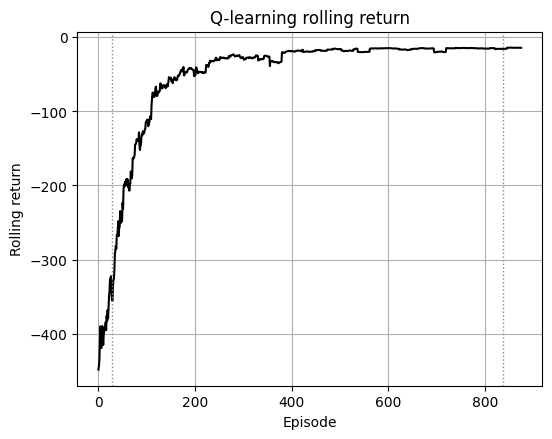

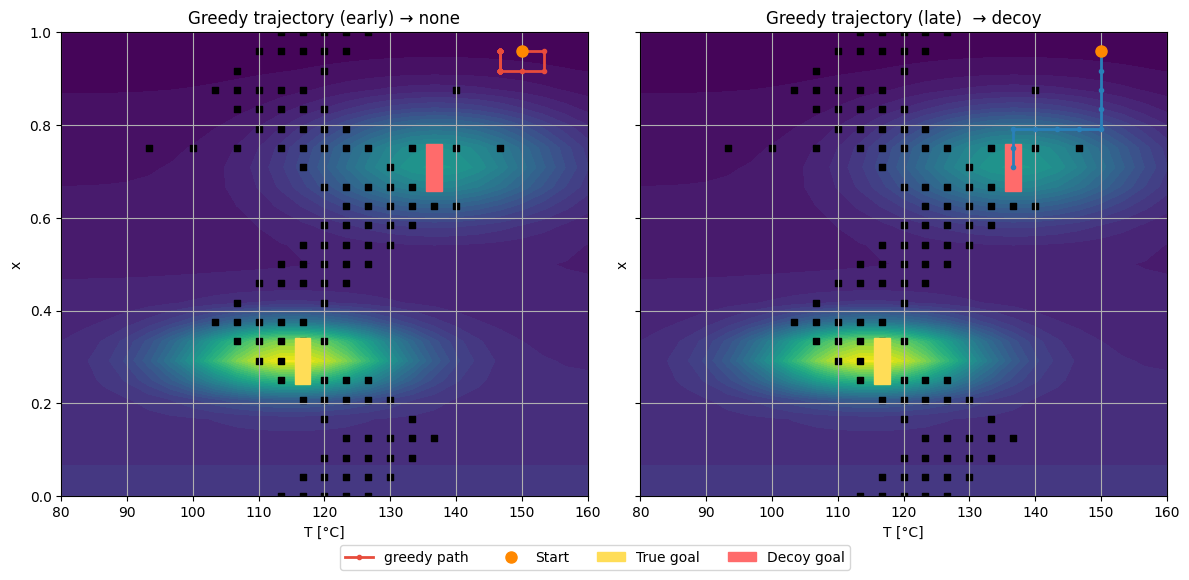

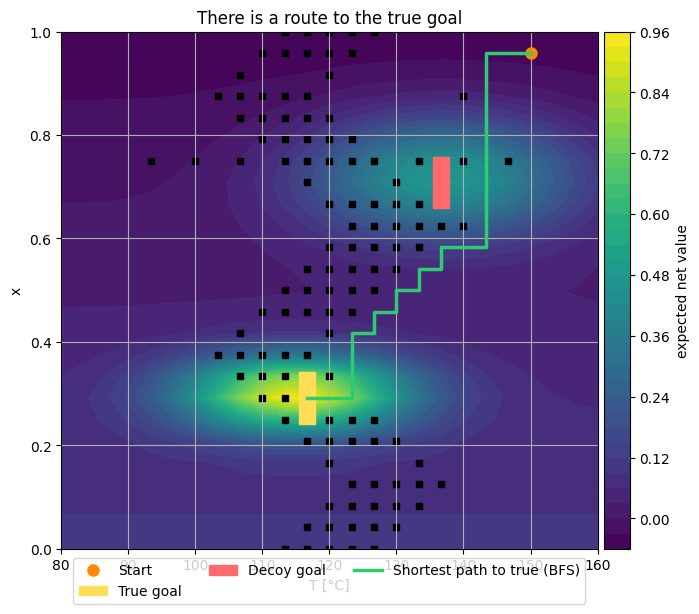

In [6]:
# Q-learning on a chemistry (T, x) grid
# Visual proof: there is a path to the true goal (BFS in green),
# early policy goes to decoy, late policy learns the true goal.

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

rng = np.random.default_rng(123)
plt.rcParams["figure.figsize"] = (6.0, 4.6)
plt.rcParams["axes.grid"] = True

# ---- Chemistry-like surface with two centers (one high, one medium) ----
def true_yield(T, x):
    T0_1, x0_1 = 115.0, 0.30   # high
    T0_2, x0_2 = 137.0, 0.72   # medium
    h1, wT1, wx1 = 0.90, 12.0, 0.05
    h2, wT2, wx2 = 0.50, 14.0, 0.08
    base = 0.10
    g1 = h1*np.exp(-0.5*((T - T0_1)/wT1)**2 - 0.5*((x - x0_1)/wx1)**2)
    g2 = h2*np.exp(-0.5*((T - T0_2)/wT2)**2 - 0.5*((x - x0_2)/wx2)**2)
    return base + g1 + g2

def expected_value(T, x):
    return true_yield(T, x) - 0.15*x

# ---- Fixed-wall environment with two reachable goals ----
class ChemGrid:
    """
    Actions: 0 up (T-), 1 right (x+), 2 down (T+), 3 left (x-)
    Reward: -1 per step, 0 at true goal, -5 at decoy goal
    Walls block movement. Pushing into a wall keeps you in place.
    """
    def __init__(self, T_vals, x_vals, start_mode="bottom_right"):
        self.T_vals = np.array(T_vals)
        self.x_vals = np.array(x_vals)
        self.nT, self.nx = len(T_vals), len(x_vals)
        self.nS, self.nA = self.nT*self.nx, 4

        Tm, Xm = np.meshgrid(self.T_vals, self.x_vals, indexing="ij")
        self.EV = expected_value(Tm, Xm)

        # Place goals by EV peaks
        gi, gj = np.unravel_index(np.argmax(self.EV), self.EV.shape)
        self.true_goal = (gi, gj)
        # second peak far from true
        self.decoy_goal = self._second_peak_far_from(self.true_goal, sep=0.35)

        # Scripted wall layout that separates regions but leaves gates
        self.wall_mask = self._build_scripted_walls()

        # Snap goals to open if needed
        self.true_goal = self._nearest_open(self.true_goal)
        self.decoy_goal = self._nearest_open(self.decoy_goal)

        # Start
        self.start = self._nearest_open(self._pick_start(start_mode))

        # Verify both are reachable. If not, open extra gates.
        self._ensure_connectivity(self.start, self.true_goal)
        self._ensure_connectivity(self.start, self.decoy_goal)

        self.reset()

    def _pick_start(self, mode):
        corners = {
            "bottom_right": (self.nT-1, self.nx-1),
            "bottom_left":  (self.nT-1, 0),
            "top_left":     (0, 0),
            "top_right":    (0, self.nx-1),
        }
        return corners.get(mode, (self.nT-1, self.nx-1))

    def _second_peak_far_from(self, avoid_ij, sep=0.35):
        ai, aj = avoid_ij
        EV = self.EV.copy()
        EV[max(0,ai-1):min(self.nT,ai+2), max(0,aj-1):min(self.nx,aj+2)] = -np.inf
        best = None; best_score = -np.inf
        for i in range(self.nT):
            for j in range(self.nx):
                if not np.isfinite(EV[i,j]): continue
                d = np.hypot((i-ai)/self.nT, (j-aj)/self.nx)
                if d < sep: continue
                if EV[i,j] > best_score:
                    best_score = EV[i,j]; best = (i,j)
        if best is None:
            best = np.unravel_index(np.argmax(EV), EV.shape)
        return best

    def _build_scripted_walls(self):
        W = np.zeros((self.nT, self.nx), dtype=bool)

        # Serpentine barrier across the grid
        mid = int(self.nT*0.48)
        for j in range(self.nx):
            wiggle = int(3*np.sin(j*np.pi/6.0))
            for k in range(-2, 3):
                i = mid + wiggle + k
                if 0 <= i < self.nT:
                    W[i, j] = True

        # Gates in the barrier
        gate_cols = [4, 10, 17, 22]
        for g in gate_cols:
            for r in [-1, 0, 1]:
                i = mid + r + int(3*np.sin(g*np.pi/6.0))
                if 0 <= i < self.nT:
                    W[i, g] = False

        # Extra maze lines near the decoy side
        for i in range(4, self.nT-4, 2):
            W[i, int(self.nx*0.72)] = True
        for j in range(int(self.nx*0.60), self.nx-2, 3):
            W[int(self.nT*0.75), j] = True

        # Do not wall the goals
        ti, tj = np.unravel_index(np.argmax(self.EV), self.EV.shape)
        W[ti, tj] = False
        di, dj = self._second_peak_far_from((ti, tj), sep=0.35)
        W[di, dj] = False

        return W

    def _nearest_open(self, ij):
        i0, j0 = ij
        if not self.wall_mask[i0, j0]:
            return (i0, j0)
        q = deque([ij]); seen = {ij}
        while q:
            i, j = q.popleft()
            for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                ni, nj = i+di, j+dj
                if ni<0 or nj<0 or ni>=self.nT or nj>=self.nx: continue
                if (ni, nj) in seen: continue
                if not self.wall_mask[ni, nj]:
                    return (ni, nj)
                seen.add((ni, nj)); q.append((ni, nj))
        return ij

    def _connected(self, src, dst):
        si, sj = src; ti, tj = dst
        if self.wall_mask[si, sj] or self.wall_mask[ti, tj]: return False
        q = deque([src]); seen = {src}
        while q:
            i, j = q.popleft()
            if (i, j) == (ti, tj): return True
            for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                ni, nj = i+di, j+dj
                if ni<0 or nj<0 or ni>=self.nT or nj>=self.nx: continue
                if (ni, nj) in seen or self.wall_mask[ni, nj]: continue
                seen.add((ni, nj)); q.append((ni, nj))
        return False

    def _ensure_connectivity(self, src, dst):
        # Open the closest barrier cells until connected
        if self._connected(src, dst):
            return
        # carve a straight tunnel along x
        si, sj = src; ti, tj = dst
        jdir = 1 if tj >= sj else -1
        for j in range(sj, tj + jdir, jdir):
            self.wall_mask[si, j] = False
        # carve along y
        idir = 1 if ti >= si else -1
        for i in range(si, ti + idir, idir):
            self.wall_mask[i, tj] = False

    def reset(self):
        self.s = tuple(self.start)
        return self.s

    def idx(self, s):
        i, j = s
        return i*self.nx + j

    def step(self, a):
        i, j = self.s
        ni, nj = i, j
        if a == 0:   ni = max(0, i-1)          # up
        elif a == 1: nj = min(self.nx-1, j+1)  # right
        elif a == 2: ni = min(self.nT-1, i+1)  # down
        elif a == 3: nj = max(0, j-1)          # left
        if self.wall_mask[ni, nj]:
            ni, nj = i, j
        done = False
        if (ni, nj) == self.true_goal:
            r = 0.0; done = True
        elif (ni, nj) == self.decoy_goal:
            r = -5.0; done = True
        else:
            r = -1.0
        self.s = (ni, nj)
        return self.s, float(r), bool(done), {}

# Build environment as usual
T_vals = np.linspace(80, 160, 25)
x_vals = np.linspace(0.0, 1.0, 25)
env = ChemGrid(T_vals, x_vals, start_mode="bottom_right")




def set_start_only(env, T_target, x_target):
    # find nearest grid indices to the desired coordinates
    iT = int(np.argmin(np.abs(env.T_vals - T_target)))
    jX = int(np.argmin(np.abs(env.x_vals - x_target)))
    # snap to an open cell but do NOT rebuild walls or goals
    if hasattr(env, "_nearest_open"):
        env.start = env._nearest_open((iT, jX))
    else:
        env.start = (iT, jX)
    env.reset()

set_start_only(env, T_target=150.0, x_target=0.95)

# optional: sanity check that EV and goals did not change
print("true goal:", env.true_goal, "decoy:", env.decoy_goal)


# ---- BFS shortest path to the true goal (to prove reachability) ----
def bfs_shortest_path(src, dst, walls):
    si, sj = src; ti, tj = dst
    q = deque([src]); parent = {src: None}
    while q:
        i, j = q.popleft()
        if (i, j) == (ti, tj):
            # reconstruct
            path = []
            cur = (ti, tj)
            while cur is not None:
                path.append(cur)
                cur = parent[cur]
            path.reverse()
            return path
        for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
            ni, nj = i+di, j+dj
            if ni<0 or nj<0 or ni>=env.nT or nj>=env.nx: continue
            if walls[ni, nj]: continue
            if (ni, nj) in parent: continue
            parent[(ni, nj)] = (i, j)
            q.append((ni, nj))
    return None

shortest_true = bfs_shortest_path(env.start, env.true_goal, env.wall_mask)

# ---- Q-learning helpers with snapshots ----
def eps_greedy(q_row, eps, local_rng):
    if local_rng.random() < eps:
        return int(local_rng.integers(0, len(q_row)))
    mx = np.max(q_row)
    cand = np.where(np.isclose(q_row, mx))[0]
    return int(local_rng.choice(cand))

def run_episode(Q, alpha=0.22, gamma=0.985, eps=0.3, seed=None, max_steps=700):
    if seed is None:
        seed = int(rng.integers(0, 10_000))
    local = np.random.default_rng(seed)
    s = env.reset()
    G = 0.0
    for _ in range(max_steps):
        si = env.idx(s)
        a = eps_greedy(Q[si], eps, local)
        s2, r, done, _ = env.step(a)
        si2 = env.idx(s2)
        Q[si, a] += alpha * (r + gamma * Q[si2].max() - Q[si, a])
        G += r
        s = s2
        if done: break
    return Q, G

def train_with_snapshots(episodes=900, eps0=0.7, eps_min=0.05, tau=350.0,
                         alpha=0.22, gamma=0.985, snaps=(40, 850)):
    Q = np.zeros((env.nS, env.nA), dtype=np.float32)
    base = np.random.default_rng(7)
    returns = []
    Q_early = None
    for ep in range(1, episodes+1):
        eps = max(eps_min, eps0 * np.exp(-ep/tau))
        Q, G = run_episode(Q, alpha=alpha, gamma=gamma, eps=eps,
                           seed=int(base.integers(0, 1_000_000)))
        returns.append(G)
        if ep == snaps[0]:
            Q_early = Q.copy()
    Q_late = Q.copy()
    return Q_early, Q_late, np.array(returns), snaps

Q_early, Q_late, ret, snaps = train_with_snapshots()

# ---- Greedy rollouts ----
def rollout(Q, max_steps=400):
    s = env.reset()
    path = [s]
    for _ in range(max_steps):
        a = int(np.argmax(Q[env.idx(s)]))
        s2, r, done, _ = env.step(a)
        path.append(s2)
        s = s2
        if done: break
    return path

path_early = rollout(Q_early)
path_late  = rollout(Q_late)

# ---- Plot 0: rolling return with snapshot markers ----
roll = np.convolve(ret, np.ones(25)/25, mode="valid")
plt.plot(roll, c="k")
for s in snaps:
    x = max(0, s - 25//2)
    plt.axvline(x=x, color="#888", lw=1, ls=":")
plt.xlabel("Episode")
plt.ylabel("Rolling return")
plt.title("Q-learning rolling return")
plt.show()

# ---- Plot 2 and 3: early vs late greedy trajectories ----
def panel(ax, path, color, title):
    cs = ax.contourf(env.T_vals, env.x_vals, env.EV.T, levels=32)
    if title.endswith("(early)"):  # colorbar on left panel
        plt.colorbar(cs, ax=ax, pad=0.01, label="expected net value")
    wi, wj = np.where(env.wall_mask)
    ax.scatter(env.T_vals[wi], env.x_vals[wj], s=18, c="k", marker="s")

    Ti = [env.T_vals[i] for i, j in path]
    Xi = [env.x_vals[j] for i, j in path]
    ax.plot(Ti, Xi, "-o", c=color, lw=2, ms=3, label="greedy path")

    ax.plot(env.T_vals[env.start[0]], env.x_vals[env.start[1]], "o", ms=8, c="#ff8800", label="Start")
    ax.add_patch(plt.Rectangle((env.T_vals[env.true_goal[0]]-1.2, env.x_vals[env.true_goal[1]]-0.05),
                               2.4, 0.10, color="#ffdd57", label="True goal"))
    ax.add_patch(plt.Rectangle((env.T_vals[env.decoy_goal[0]]-1.2, env.x_vals[env.decoy_goal[1]]-0.05),
                               2.4, 0.10, color="#ff6b6b", label="Decoy goal"))
    ax.set_xlabel("T [°C]"); ax.set_ylabel("x")
    ax.set_title(title)

end_early = path_early[-1]
end_late  = path_late[-1]
early_tag = "decoy" if end_early == env.decoy_goal else ("true" if end_early == env.true_goal else "none")
late_tag  = "true"  if end_late  == env.true_goal  else ("decoy" if end_late  == env.decoy_goal  else "none")

fig, axs = plt.subplots(1, 2, figsize=(12, 5.6), sharex=True, sharey=True)
panel(axs[0], path_early, "#e74c3c", f"Greedy trajectory (early) → {early_tag}")
panel(axs[1], path_late,  "#2980b9", f"Greedy trajectory (late)  → {late_tag}")

# single legend bottom
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
seen = set(); H = []; L = []
for h, l in zip(handles, labels):
    if l in seen: continue
    seen.add(l); H.append(h); L.append(l)

fig.legend(H, L, loc="lower center", bbox_to_anchor=(0.5, -0.04), ncol=4)
plt.tight_layout()
plt.show()


# ---- Plot 1: EV + walls + both goals + BFS shortest path to true ----
EV = env.EV
fig, ax = plt.subplots(figsize=(7.2, 6.2))
cs = ax.contourf(env.T_vals, env.x_vals, env.EV.T, levels=32)
plt.colorbar(cs, ax=ax, pad=0.01, label="expected net value")

# walls
wi, wj = np.where(env.wall_mask)
ax.scatter(env.T_vals[wi], env.x_vals[wj], s=18, c="k", marker="s")

# goals and start
ax.plot(env.T_vals[env.start[0]], env.x_vals[env.start[1]], "o", ms=8, c="#ff8800", label="Start")
ax.add_patch(plt.Rectangle((env.T_vals[env.true_goal[0]]-1.2, env.x_vals[env.true_goal[1]]-0.05),
                           2.4, 0.10, color="#ffdd57", label="True goal"))
ax.add_patch(plt.Rectangle((env.T_vals[env.decoy_goal[0]]-1.2, env.x_vals[env.decoy_goal[1]]-0.05),
                           2.4, 0.10, color="#ff6b6b", label="Decoy goal"))

# shortest path to true
if shortest_true is not None:
    Ti = [env.T_vals[i] for i, j in shortest_true]
    Xi = [env.x_vals[j] for i, j in shortest_true]
    ax.plot(Ti, Xi, "-", c="#2ecc71", lw=2.5, label="Shortest path to true (BFS)")

ax.set_xlabel("T [°C]")
ax.set_ylabel("x")
ax.set_title("There is a route to the true goal")
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.12), ncol=3)
plt.tight_layout()
plt.show()

Early training has fewer updates. The path to the true goal is long and costs many `-1` steps before the +100 reward at the goal.

The decoy has a terminal penalty (for example `−50`) but may sit behind short corridors. Early Q often overestimates short routes and underestimates long ones. Greedy on an undertrained Q picks the locally better-looking path, which is often the decoy.

```{admonition} Note
With more episodes the updates push up Q along the route to the true goal and push down Q around the decoy due to its terminal penalty. Then greedy flips to the true route.
```
---

## 4. Bridge to Multi-Armed Bandits

In chemical research we often choose the **next experiment anywhere in the space**, informed by past data (as in Bayesian optimization and active learning we learned in the previous lecture). Unlike a reinforcement learning (RL) grid world shown above, in practice it's less frequent that we move only to *neighboring* conditions (like "up", "down", "left", "right") after each reaction.

Instead, every experiment can be any point in the search space.  

Because there is no meaningful notion of “current position” (enviroment), we can simplify the RL setup:  
there is effectively **only one state** that repeats each round.
This simplification leads to the **multi-armed bandit** formulation.

Under this one-state bandit setting, think about doing experiment in your lab like going to casino, we have $K$ possible actions (arms), each representing an experimental condition such as a catalyst, solvent, or temperature combination.  

Each arm $i$ has an unknown expected reward $\mu_i$ (e.g., expected yield) for different reactions (for example, reaction time 12h give an average reaction yield for suzuki coupling on 70% for 100 substrates, while 200C only give 10% success rate for the same pool of substrates).

At each trial $t = 1, 2, \dots, T$:

1. Select an arm $A_t \in \{1, \dots, K\}$  
2. Observe a reward $R_t$ drawn from a distribution with mean $\mu_{A_t}$  
3. Update your estimates based on what you learned

The objective is to maximize the **total reward**:

$$
\max \; \mathbb{E}\!\left[\sum_{t=1}^{T} R_t\right]
$$

or equivalently, to minimize the **regret**, which measures how much we lose compared to always picking the best arm:

$$
\mathcal{R}_T = T \mu^* - \mathbb{E}\!\left[\sum_{t=1}^T R_t\right],
\quad
\text{where } \mu^* = \max_i \mu_i
$$


Below is a mini-game to give you an idea of this:

- Each arm (catalyst or condition) is like a slot machine with an unknown payout probability.  
- You can pull one arm per round — that’s one experiment.  
- After observing the outcome (success or yield), update your belief about that arm.  
- Decide whether to **explore** new arms or **exploit** the best one so far.

In [7]:
from IPython.display import HTML

HTML(r"""
<div id="bandit-chemlab" style="font-family: ui-sans-serif, system-ui, -apple-system, Segoe UI, Roboto, Helvetica, Arial; color:#e6e6e6;">
  <div style="background:#0b1021;border:1px solid #1e2a44;border-radius:12px;padding:14px;box-shadow:0 8px 24px rgba(0,0,0,.35);">
    <h3 style="margin:0 0 .4rem 0;color:#ffd84d;">ChemLab: explore vs exploit</h3>
    <p style="margin:.2rem 0 1rem 0;opacity:.95">
      You are screening <b>catalysts</b> for a reaction. Each catalyst has an unknown success rate (yield).
      You can run one experiment per round. Try a strategy:
      <b>explore</b> new catalysts to learn their true performance or <b>exploit</b> the best one you know so far.
      Compare strategies and watch how average yield and regret evolve.
    </p>

    <div style="display:flex;flex-wrap:wrap;gap:12px;align-items:flex-start;">
      <!-- Controls -->
      <div style="flex:1 1 280px;min-width:280px;background:#0f1329;border:1px solid #1f2a48;border-radius:10px;padding:10px;">
        <div style="display:flex;gap:8px;flex-wrap:wrap;align-items:center;margin-bottom:8px;">
          <span>Mode:</span>
          <label style="display:flex;align-items:center;gap:.35rem;"><input type="radio" name="algo" value="Manual" checked> Manual</label>
          <label style="display:flex;align-items:center;gap:.35rem;"><input type="radio" name="algo" value="Eps"> ε-greedy</label>
          <label style="display:flex;align-items:center;gap:.35rem;"><input type="radio" name="algo" value="UCB"> UCB1</label>
          <label style="display:flex;align-items:center;gap:.35rem;"><input type="radio" name="algo" value="TS"> Thompson</label>
        </div>
        <div id="panel-eps" style="display:none;margin:.3rem 0 .4rem 0;">
          <label>ε explore:
            <input id="epsSlider" type="range" min="0" max="1" step="0.01" value="0.10">
            <span id="epsVal">0.10</span>
          </label>
        </div>
        <div style="display:flex;gap:8px;flex-wrap:wrap;align-items:center;margin:.6rem 0;">
          <label>Steps/run:
            <input id="stepsSlider" type="range" min="1" max="300" step="1" value="5">
            <span id="stepsVal">50</span>
          </label>
        </div>
        <div style="display:flex;gap:8px;flex-wrap:wrap;margin-top:.2rem;">
          <button id="runBtn"   style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Run agent</button>
          <button id="stepBtn"  style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Step 1</button>
          <button id="resetBtn" style="padding:.4rem .7rem;border:1px solid #222;border-radius:.5rem;background:#111;color:#eee;cursor:pointer;">Reset</button>
          <label style="margin-left:auto;display:flex;align-items:center;gap:.35rem;">
            <input id="revealChk" type="checkbox"> Reveal true yields
          </label>
        </div>
        <div style="margin-top:.6rem;font-size:.95rem;opacity:.9;line-height:1.35;">
          <b>Keys</b>: press 1..8 to test a catalyst in Manual mode.
          <b>Story</b>: think of each catalyst as a recipe variant with its own success rate.
          Your goal is to maximize average yield while keeping regret low.
        </div>
      </div>

      <!-- Charts -->
      <div style="flex:2 1 520px;min-width:520px;display:grid;grid-template-columns:1fr 1fr;gap:12px;">
        <div style="background:#0f1329;border:1px solid #1f2a48;border-radius:10px;padding:10px;">
          <div style="display:flex;justify-content:space-between;align-items:center;margin-bottom:6px;">
            <div>Estimated yield by catalyst</div>
            <div id="labelline" style="opacity:.8;font-size:.9rem;"></div>
          </div>
          <canvas id="barChart" width="520" height="300" style="width:100%;height:auto;display:block;background:#0b1021;border-radius:8px;"></canvas>
          <div style="margin-top:6px;opacity:.8;">Click a bar in Manual mode to run that experiment.</div>
        </div>
        <div style="background:#0f1329;border:1px solid #1f2a48;border-radius:10px;padding:10px;">
          <div>Average yield and cumulative regret</div>
          <canvas id="lineChart" width="520" height="300" style="width:100%;height:auto;display:block;background:#0b1021;border-radius:8px;"></canvas>
          <div style="margin-top:6px;opacity:.8;"><span style="color:#91d5ff;">Avg yield</span> should climb. <span style="color:#ffa39e;">Regret</span> should grow more slowly when you find the best catalyst.</div>
        </div>
      </div>
    </div>
  </div>
</div>

<script>
(() => {
  // ---------- Helpers ----------
  const clamp = (v, lo, hi)=>Math.max(lo, Math.min(hi, v));
  function randChoice(arr){ return arr[Math.floor(Math.random()*arr.length)]; }

  // ---------- Environment: Bernoulli bandit in chemistry flavor ----------
  // 8 catalysts with fixed true success rates (hidden)
  const labels = ["Cat A","Cat B","Cat C","Cat D","Cat E","Cat F","Cat G","Cat H"];
  const trueP = (()=>{
    // One clearly best, one close, rest mixed
    return [0.78, 0.72, 0.48, 0.44, 0.36, 0.30, 0.25, 0.18];
  })();
  const K = trueP.length;
  const bestIdx = trueP.indexOf(Math.max(...trueP));

  // ---------- State ----------
  let t = 0;
  let est = Array(K).fill(0);       // running mean per arm
  let pulls = Array(K).fill(0);     // count per arm
  let postA = Array(K).fill(1);     // Thompson alpha
  let postB = Array(K).fill(1);     // Thompson beta
  let rewards = [];                 // 0/1 outcomes
  let regret = [];                  // cumulative regret
  let cumReward = 0;

  // UI refs
  const barCanvas  = document.getElementById("barChart");
  const lineCanvas = document.getElementById("lineChart");
  const ctxBar  = barCanvas.getContext("2d");
  const ctxLine = lineCanvas.getContext("2d");
  const labelline = document.getElementById("labelline");

  const epsSlider   = document.getElementById("epsSlider");
  const epsVal      = document.getElementById("epsVal");
  const stepsSlider = document.getElementById("stepsSlider");
  const stepsVal    = document.getElementById("stepsVal");
  const revealChk   = document.getElementById("revealChk");
  const runBtn      = document.getElementById("runBtn");
  const stepBtn     = document.getElementById("stepBtn");
  const resetBtn    = document.getElementById("resetBtn");
  const radioAlgos  = [...document.querySelectorAll('input[name="algo"]')];
  const panelEps    = document.getElementById("panel-eps");

  // ---- UI sync
  epsSlider.oninput = ()=> epsVal.textContent = Number(epsSlider.value).toFixed(2);
  stepsSlider.oninput = ()=> stepsVal.textContent = stepsSlider.value;
  epsVal.textContent = Number(epsSlider.value).toFixed(2);
  stepsVal.textContent = stepsSlider.value;

  function getAlgo(){
    const a = radioAlgos.find(r=>r.checked).value;
    return a;
  }
  radioAlgos.forEach(r => r.onchange = ()=>{
    panelEps.style.display = (getAlgo()==="Eps") ? "block" : "none";
  });

  // ---------- Algorithms ----------
  function actEpsGreedy(){
    const eps = Number(epsSlider.value);
    if(Math.random() < eps){
      return Math.floor(Math.random()*K);
    }
    const m = Math.max(...est);
    const cand = [];
    for(let i=0;i<K;i++) if(Math.abs(est[i]-m)<1e-12) cand.push(i);
    return randChoice(cand);
  }
  function actUCB1(){
    // Pull each arm once at start
    for(let i=0;i<K;i++) if(pulls[i]===0) return i;
    const logt = Math.log(t+1);
    let best = -1, bestVal = -Infinity;
    for(let i=0;i<K;i++){
      const bonus = Math.sqrt(2*logt / pulls[i]);
      const ucb = est[i] + bonus;
      if(ucb > bestVal - 1e-12){ bestVal = ucb; best = i; }
    }
    return best;
  }
  function actThompson(){
    let samples = [];
    for(let i=0;i<K;i++){
      // simple Beta sampler using Math.random + inverse CDF approx is heavy; use JS gamma trick
      // Here we approximate with many small sum uniforms for simplicity
      // Quick and light: sample using library-free approximation
      const a = postA[i], b = postB[i];
      // Cheng's algorithm would be better, but for teaching this light approx is fine
      // Fallback: draw 100 uniforms and average to get a rough rank
      let sA=0, sB=0;
      for(let k=0;k<Math.max(2, Math.floor(a));k++) sA += Math.random();
      for(let k=0;k<Math.max(2, Math.floor(b));k++) sB += Math.random();
      const betaLike = sA/(sA+sB+1e-9);
      samples.push(betaLike);
    }
    const m = Math.max(...samples);
    const cand = [];
    for(let i=0;i<K;i++) if(Math.abs(samples[i]-m)<1e-12) cand.push(i);
    return randChoice(cand);
  }

  // ---------- One round ----------
  function bernoulliDraw(p){ return Math.random() < p ? 1 : 0; }

  function stepOnce(action){
    const r = bernoulliDraw(trueP[action]);
    t += 1;
    cumReward += r;
    const bestMean = trueP[bestIdx];
    regret.push(bestMean*t - cumReward);

    // update estimates
    pulls[action] += 1;
    const n = pulls[action];
    est[action] += (r - est[action]) / n;

    // update Thompson posterior
    postA[action] += r;
    postB[action] += 1 - r;

    rewards.push(r);
  }

  // ---------- Drawing ----------
  function drawBars(){
    const W = barCanvas.width, H = barCanvas.height;
    ctxBar.clearRect(0,0,W,H);
    // axes
    ctxBar.strokeStyle = "#243042"; ctxBar.lineWidth = 1;
    ctxBar.beginPath(); ctxBar.moveTo(40,10); ctxBar.lineTo(40,H-30); ctxBar.lineTo(W-10,H-30); ctxBar.stroke();

    const maxY = 1.0;
    const plotW = W-60, plotH = H-50;
    const bw = plotW / K * 0.7;
    const gap = plotW / K * 0.3;
    const x0 = 40 + gap*0.5;

    // gridlines
    ctxBar.strokeStyle = "rgba(255,255,255,.06)";
    for(let y=0;y<=10;y++){
      const yy = 10 + plotH - plotH*(y/10);
      ctxBar.beginPath(); ctxBar.moveTo(40, yy); ctxBar.lineTo(W-10, yy); ctxBar.stroke();
    }

    // bars
      for(let i=0;i<K;i++){
        const x = x0 + i*(bw+gap);
        const y = 10 + plotH - plotH*clamp(est[i]/maxY,0,1);
        const h = plotH - (y-10);
        ctxBar.fillStyle = "#51cf66";
        ctxBar.fillRect(x, y, bw, h);

        // SUCCESS / TOTAL on top
        const succ = Math.max(0, postA[i] - 1);   // successes tracked via Beta alpha
        const total = pulls[i];                    // total runs for this catalyst
        ctxBar.fillStyle = "#e6e6e6";
        ctxBar.font = "12px ui-sans-serif";
        ctxBar.textAlign = "center";
        ctxBar.fillText(`${succ}/${total}`, x + bw/2, y - 6);

        // catalyst label
        ctxBar.fillStyle = "#a3b3c2";
        ctxBar.save();
        ctxBar.translate(x + bw/2, H-15);
        ctxBar.rotate(-0.1);
        ctxBar.fillText(labels[i], 0, 0);
        ctxBar.restore();

        // true mean overlay if reveal
        if(revealChk.checked){
          const yTrue = 10 + plotH - plotH*clamp(trueP[i]/maxY,0,1);
          ctxBar.strokeStyle = "#ffd84d";
          ctxBar.beginPath(); ctxBar.moveTo(x, yTrue); ctxBar.lineTo(x+bw, yTrue); ctxBar.stroke();
        }
      }

    labelline.textContent = `Rounds ${t} | Best true catalyst = ${labels[bestIdx]}`;
    // capture clickable bar bounds
    clickRegions = [];
    for(let i=0;i<K;i++){
      const x = x0 + i*(bw+gap);
      clickRegions.push({i, x, w:bw, y:10, h:plotH});
    }
  }

  function drawLines(){
    const W = lineCanvas.width, H = lineCanvas.height;
    ctxLine.clearRect(0,0,W,H);
    // axes
    ctxLine.strokeStyle = "#243042"; ctxLine.lineWidth = 1;
    ctxLine.beginPath(); ctxLine.moveTo(40,10); ctxLine.lineTo(40,H-30); ctxLine.lineTo(W-10,H-30); ctxLine.stroke();

    const plotW = W-60, plotH = H-50;
    // grid
    ctxLine.strokeStyle = "rgba(255,255,255,.06)";
    for(let y=0;y<=10;y++){
      const yy = 10 + plotH - plotH*(y/10);
      ctxLine.beginPath(); ctxLine.moveTo(40, yy); ctxLine.lineTo(W-10, yy); ctxLine.stroke();
    }
    // avg reward
    if(t>0){
      const avg = []; let s=0;
      for(let i=0;i<rewards.length;i++){ s+=rewards[i]; avg.push(s/(i+1)); }

      ctxLine.strokeStyle = "#91d5ff"; ctxLine.lineWidth = 2;
      ctxLine.beginPath();
      for(let i=0;i<avg.length;i++){
        const x = 40 + plotW * (i/(rewards.length-1 || 1));
        const y = 10 + plotH - plotH*clamp(avg[i],0,1);
        if(i===0) ctxLine.moveTo(x,y); else ctxLine.lineTo(x,y);
      }
      ctxLine.stroke();

      // regret (rescale to fit nicely)
      const reg = regret.slice();
      const maxReg = Math.max(1, ...reg);
      ctxLine.strokeStyle = "#ffa39e"; ctxLine.lineWidth = 2;
      ctxLine.beginPath();
      for(let i=0;i<reg.length;i++){
        const x = 40 + plotW * (i/(reg.length-1 || 1));
        const y = 10 + plotH - plotH*clamp(reg[i]/maxReg,0,1);
        if(i===0) ctxLine.moveTo(x,y); else ctxLine.lineTo(x,y);
      }
      ctxLine.stroke();
    }
  }

  // ---------- Interaction ----------
  let clickRegions = []; // set by drawBars()

  function canvasToLocal(canvas, evt){
    const r = canvas.getBoundingClientRect();
    const scaleX = canvas.width / r.width;
    const scaleY = canvas.height / r.height;
    return { x: (evt.clientX - r.left) * scaleX, y: (evt.clientY - r.top) * scaleY };
    }

  barCanvas.addEventListener("click", (e)=>{
    if(getAlgo()!=="Manual") return;
    const p = canvasToLocal(barCanvas, e);
    for(const reg of clickRegions){
      if(p.x>=reg.x && p.x<=reg.x+reg.w && p.y>=reg.y && p.y<=reg.y+reg.h){
        stepOnce(reg.i);
        drawBars(); drawLines();
        return;
      }
    }
  });

  // keyboard 1..8
  window.addEventListener("keydown", (e)=>{
    if(getAlgo()!=="Manual") return;
    if(e.key>="1" && e.key<="8"){
      const i = parseInt(e.key,10)-1;
      if(i>=0 && i<K){ stepOnce(i); drawBars(); drawLines(); }
    }
  });

  // Buttons
  runBtn.onclick = ()=>{
    const algo = getAlgo();
    if(algo==="Manual") return;
    const steps = parseInt(stepsSlider.value,10);
    for(let s=0;s<steps;s++){
      let a = 0;
      if(algo==="Eps") a = actEpsGreedy();
      else if(algo==="UCB") a = actUCB1();
      else if(algo==="TS")  a = actThompson();
      stepOnce(a);
    }
    drawBars(); drawLines();
  };

  stepBtn.onclick = ()=>{
    const algo = getAlgo();
    if(algo==="Manual") return;
    let a = 0;
    if(algo==="Eps") a = actEpsGreedy();
    else if(algo==="UCB") a = actUCB1();
    else if(algo==="TS")  a = actThompson();
    stepOnce(a);
    drawBars(); drawLines();
  };

  resetBtn.onclick = ()=>{
    t=0; est=Array(K).fill(0); pulls=Array(K).fill(0);
    postA=Array(K).fill(1); postB=Array(K).fill(1);
    rewards=[]; regret=[]; cumReward=0;
    drawBars(); drawLines();
  };

  // Initial draw
  drawBars(); drawLines();
})();
</script>
""")

Below are the equations we use for the above examples:


**ε-greedy**: explore random arm with prob ε, otherwise pick highest mean estimate.
`est = s/n` is average reward per arm; we update counts each step.
`avg` is cumulative average reward over time.

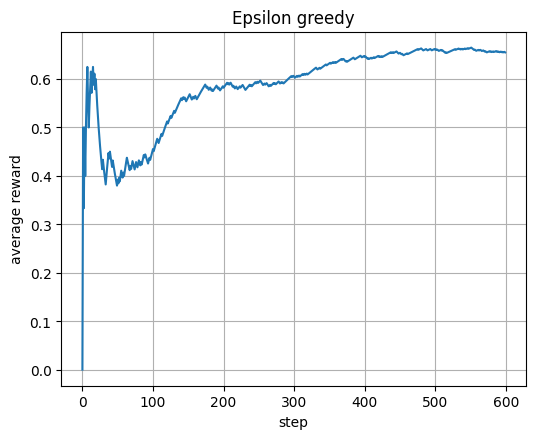

In [8]:
means = np.array([0.78, 0.72, 0.48, 0.44, 0.36, 0.30, 0.25, 0.18], dtype=float) #cat A to H
K = len(means)
def pull(arm, rng):
    return float(rng.binomial(1, means[arm]))

# ε-greedy (simple math: est = s/n, pick max; cum avg = total/t)
def run_eps_greedy(T=600, eps=0.1, seed=2):
    rng = np.random.default_rng(seed)
    n = np.zeros(K, int); s = np.zeros(K, float)
    avg = []; total = 0.0
    for t in range(1, T+1):
        if rng.random() < eps:
            a = int(rng.integers(0, K))
        else:
            est = s / np.maximum(1, n)
            ties = np.flatnonzero(est == est.max())
            a = int(rng.choice(ties))
        r = pull(a, rng); n[a] += 1; s[a] += r; total += r
        avg.append(total / t)
    return np.array(avg), n, s

avg_e, n_e, s_e = run_eps_greedy()
plt.plot(avg_e); plt.xlabel("step"); plt.ylabel("average reward"); plt.title("Epsilon greedy"); plt.show()


**UCB1**: each arm starts once; after that use `est + sqrt(2 ln t / n)`.
This bonus term encourages **early exploration** and **later exploitation**.
`avg` shows how the average reward improves over time.

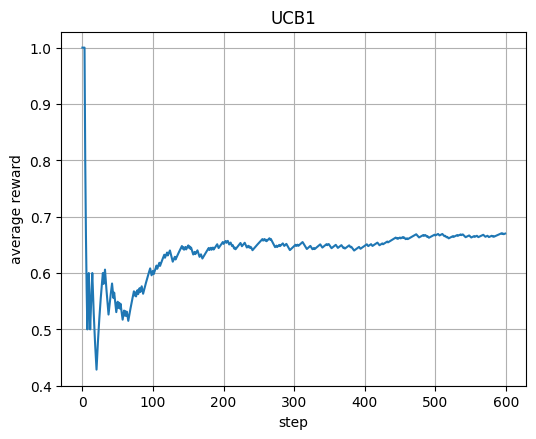

In [9]:
# UCB1 (simple math: est = s/n, bonus = sqrt(2 ln t / n); cum avg)
def run_ucb1(T=600, seed=3):
    rng = np.random.default_rng(seed)
    n = np.zeros(K, int); s = np.zeros(K, float)
    avg = []; total = 0.0
    # pull each arm once
    for a in range(K):
        r = pull(a, rng); n[a] += 1; s[a] += r; total += r
        avg.append(total / (a+1))
    # then UCB
    for t in range(K+1, T+1):
        est = s / n
        bonus = np.sqrt(2.0 * np.log(t) / n)
        a = int(np.argmax(est + bonus))
        r = pull(a, rng); n[a] += 1; s[a] += r; total += r
        avg.append(total / t)
    return np.array(avg), n, s

avg_u, n_u, s_u = run_ucb1()
plt.plot(avg_u); plt.xlabel("step"); plt.ylabel("average reward"); plt.title("UCB1"); plt.show()


**Thompson sampling**: each arm has `Beta(a,b)` belief; sample, pick highest.
Update `a+=r` (success) and `b+=(1−r)` (failure) each step.
`avg` shows how Bayesian exploration converges to best catalyst.

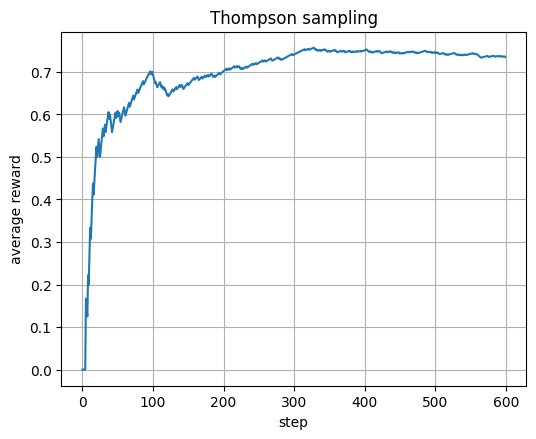

In [10]:
# Thompson (simple math: Beta(a,b); sample; update a+=r, b+=(1-r); cum avg)
def run_thompson(T=600, seed=4):
    rng = np.random.default_rng(seed)
    a_cnt = np.ones(K); b_cnt = np.ones(K)
    avg = []; total = 0.0
    for t in range(1, T+1):
        samples = rng.beta(a_cnt, b_cnt)
        a = int(np.argmax(samples))
        r = pull(a, rng); total += r
        a_cnt[a] += r; b_cnt[a] += (1.0 - r)
        avg.append(total / t)
    return np.array(avg), a_cnt, b_cnt

avg_t, a_t, b_t = run_thompson()
plt.plot(avg_t); plt.xlabel("step"); plt.ylabel("average reward"); plt.title("Thompson sampling"); plt.show()


Beta(a,b) belief:
Each curve below shows how the distribution changes as successes (`a`) and failures (`b`) grow.

- High a → belief shifts toward 1. 

- High b → belief shifts toward 0.

`Beta(1,1)` is uniform (complete uncertainty).

`Beta(1,1)` → flat line (no knowledge yet).

`Beta(5,2)` → skewed right (we’ve seen mostly successes).

`Beta(2,5)` → skewed left (mostly failures).

As counts rise (e.g., `Beta(20,5)`), the curve narrows — higher confidence in the estimate.

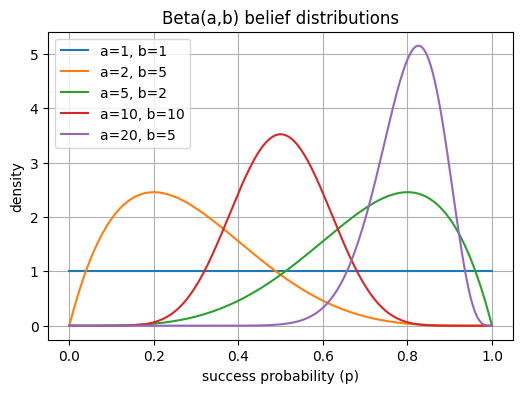

In [11]:
"""
Beta(a,b) belief plot:
Each curve shows how the distribution changes as successes (a) and failures (b) grow.
High a → belief shifts toward 1. High b → belief shifts toward 0.
Beta(1,1) is uniform (complete uncertainty).
"""
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import beta

x = np.linspace(0, 1, 200)
params = [(1,1), (2,5), (5,2), (10,10), (20,5)]
plt.figure(figsize=(6,4))
for a,b in params:
    plt.plot(x, beta.pdf(x, a, b), label=f"a={a}, b={b}")
plt.title("Beta(a,b) belief distributions")
plt.xlabel("success probability (p)")
plt.ylabel("density")
plt.legend()
plt.show()

---

## 5. Case study: MOF synthesis as a bandit on yield

We will use the synthetic MOF dataset we seen in the last lecture. It records outcomes for combinations of `temperature`, `time`, `concentration`, `solvent identity`, and the `organic linker`. 

For this version we focus on **yield only** in the range [0, 1]. The goal is to find **general synthesis conditions** that give high yield for each of 10 linkers. 

The dataset acts as our simulator. Each time the bandit chooses a recipe the simulator samples a matching row and returns its yield. 

```{admonition} Note
For this section, please use Google Colab to run.
Below only code is shown.
```
### 5.1 Load and process the dataset

In [12]:
# Load full dataset
url = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/mof_yield_dataset.csv"
df_raw = pd.read_csv(url)

# Pick the 10 most frequent linkers so each has adequate coverage in the table
top_linkers = df_raw['smiles'].value_counts().head(10).index.tolist()

def linker_actions(df_like, linker):
    """All condition tuples that actually exist for this linker."""
    sub = df_like[df_like['smiles'] == linker]
    acts = (
        sub[['temperature','time_h','concentration_M','solvent_DMF']]
        .drop_duplicates()
        .itertuples(index=False, name=None)
    )
    return list(acts)

def make_pull_yield(df_like, linker, acts):
    """
    Return a function pull(action, rng) -> yield in [0,1], sampling from rows observed for this linker+action.
    If an action is not present for the linker it is skipped upstream, so we do not synthesize data.
    """
    pools = {}
    sub_all = df_like[df_like['smiles'] == linker]
    for a in acts:
        T,H,C,S = a
        pool = sub_all[
            (sub_all['temperature'] == T) &
            (sub_all['time_h'] == H) &
            (sub_all['concentration_M'] == C) &
            (sub_all['solvent_DMF'] == S)
        ]
        if not pool.empty:
            pools[a] = pool.reset_index(drop=True)

    def pull_fn(a, rng):
        pool = pools.get(a)
        if pool is None or len(pool) == 0:
            return None
        row = pool.iloc[int(rng.integers(0, len(pool)))]
        return float(row['yield'])
    return pull_fn

def fmt_action(a):
    T,H,C,S = a
    return f"T={T}°C, t={H}h, c={C:.2f} M, solvent={'DMF' if S==1 else 'H2O'}"

### 5.2 Bandit framing and algorithms
We treat each unique recipe as an arm and the yield as the reward. Rewards are bounded in `[0, 1]`, which suits UCB1 on sample means. 

For Thompson sampling we use a Beta posterior heuristic that accumulates alpha plus equal to yield and beta plus equal to 1 minus yield. This gives a simple way to sample optimistic beliefs for continuous bounded outcomes without converting to binary success. We also include ε greedy on the mean yield for a familiar baseline. 

All algorithms run per linker so each linker gets a focused search over the actions that actually appear in the data.

In [13]:
# Section 2: Bandit agents for bounded rewards in [0,1]

def run_eps_mean_linker(df_like, linker, Tsteps=400, eps=0.1, seed=0):
    acts = linker_actions(df_like, linker)
    if len(acts) == 0:
        return dict(avg=np.array([]), n=np.array([]), s=np.array([]), best=None, acts=[])
    rng = np.random.default_rng(seed)
    K = len(acts)
    n = np.zeros(K, int)           # pulls
    s = np.zeros(K, float)         # sum of yields
    avg = []; total = 0.0
    pull = make_pull_yield(df_like, linker, acts)
    for t in range(1, Tsteps+1):
        if rng.random() < eps:
            a = int(rng.integers(0, K))
        else:
            est = s / np.maximum(1, n)
            m = est.max(); ties = np.flatnonzero(np.isclose(est, m))
            a = int(rng.choice(ties))
        r = pull(acts[a], rng)
        if r is None:
            continue
        n[a]+=1; s[a]+=r; total+=r
        avg.append(total/t)
    if n.sum()==0:
        return dict(avg=np.array([]), n=n, s=s, best=None, acts=acts)
    best = int(np.argmax(s/np.maximum(1,n)))
    return dict(avg=np.asarray(avg), n=n, s=s, best=best, acts=acts)

def run_ucb1_mean_linker(df_like, linker, Tsteps=400, seed=0):
    acts = linker_actions(df_like, linker)
    if len(acts) == 0:
        return dict(avg=np.array([]), n=np.array([]), s=np.array([]), best=None, acts=[])
    rng = np.random.default_rng(seed)
    K = len(acts)
    n = np.zeros(K, int); s = np.zeros(K, float)
    avg = []; total = 0.0
    pull = make_pull_yield(df_like, linker, acts)
    # small warm start to avoid zero-division
    tried = 0
    for a in range(min(K, 10)):
        r = pull(acts[a], rng)
        if r is None: 
            continue
        n[a]+=1; s[a]+=r; total+=r; tried += 1
        avg.append(total/tried)
    for t in range(tried+1, Tsteps+1):
        est = s/np.maximum(1,n)
        bonus = np.sqrt(2.0*np.log(max(2, t))/np.maximum(1,n))
        a = int(np.argmax(est + bonus))
        r = pull(acts[a], rng)
        if r is None: 
            continue
        n[a]+=1; s[a]+=r; total+=r
        avg.append(total/(len(avg)+1))
    if n.sum()==0:
        return dict(avg=np.array([]), n=n, s=s, best=None, acts=acts)
    best = int(np.argmax(s/np.maximum(1,n)))
    return dict(avg=np.asarray(avg), n=n, s=s, best=best, acts=acts)

def run_thompson_beta_linker(df_like, linker, Tsteps=400, seed=0):
    """
    Thompson with a Beta posterior heuristic for bounded yields.
    alpha += yield, beta += 1 - yield.
    """
    acts = linker_actions(df_like, linker)
    if len(acts) == 0:
        return dict(avg=np.array([]), n=np.array([]), s=np.array([]), best=None, acts=[])
    rng = np.random.default_rng(seed)
    K = len(acts)
    alpha = np.ones(K); beta = np.ones(K)
    n = np.zeros(K, int); s = np.zeros(K, float)
    avg = []; total = 0.0
    pull = make_pull_yield(df_like, linker, acts)
    for t in range(1, Tsteps+1):
        samples = rng.beta(alpha, beta)
        a = int(np.argmax(samples))
        r = pull(acts[a], rng)
        if r is None: 
            continue
        n[a]+=1; s[a]+=r; total+=r
        alpha[a] += r
        beta[a]  += (1.0 - r)
        avg.append(total/t)
    if n.sum()==0:
        return dict(avg=np.array([]), n=n, s=s, best=None, acts=acts)
    best = int(np.argmax(s/np.maximum(1,n)))
    return dict(avg=np.asarray(avg), n=n, s=s, best=best, acts=acts)

def summarize_agent(linker, name, out):
    best = out["best"]; acts = out["acts"]
    if best is None or len(acts) == 0:
        return dict(linker=linker, agent=name, recipe="NA", pulls=0, mean_yield=np.nan)
    n, s = out["n"], out["s"]
    return dict(
        linker=linker, agent=name,
        recipe=fmt_action(acts[best]),
        pulls=int(n[best]),
        mean_yield=float(s[best]/max(1,n[best]))
    )


### 5.3  Running the agents and building a compact report

We now run `ε greedy`, `UCB1`, and `Thompson Beta` for **each of the 10 linkers**. Each agent interacts with a simulator that returns yields for recipes that are actually in the table for that linker. 

We then summarize the **best recipe per agent** by its *mean* yield and also produce one recommended recipe per linker by taking the top mean yield across agents. This gives a short list of general conditions to try first in the lab for each linker.

In [14]:
# Section 3: Execute agents and summarize best recipes per linker

results = []
curves = []

for linker in top_linkers:
    eps = run_eps_mean_linker     (df_raw, linker, Tsteps=50, eps=0.1, seed=42)
    ucb = run_ucb1_mean_linker    (df_raw, linker, Tsteps=50, seed=42)
    ts  = run_thompson_beta_linker(df_raw, linker, Tsteps=50, seed=42)

    results.extend([
        summarize_agent(linker, "eps_greedy", eps),
        summarize_agent(linker, "ucb1", ucb),
        summarize_agent(linker, "thompson_beta", ts),
    ])
    curves.append((linker, eps.get("avg", np.array([])), ucb.get("avg", np.array([])), ts.get("avg", np.array([]))))

summary_df = pd.DataFrame(results).sort_values(["linker","mean_yield"], ascending=[True, False]).reset_index(drop=True)
print("Per-linker best by agent (first 12 rows):")
summary_df.head(12)

In [ ]:
best_by_linker = (
    summary_df
    .groupby("linker", as_index=False)
    .first()[["linker","agent","recipe","pulls","mean_yield"]]
)
print("\nOne recommended recipe per linker by highest mean yield across agents:")
best_by_linker

### 5.4 Interpreting the results and tracking learning

The table lists a best recipe per agent for each linker together with the number of pulls used to estimate its mean yield. If a best recipe shows very few pulls you can increase the step budget or run another pass to confirm stability. Learning curves help you see whether the agent is still exploring or has stabilized on a high yielding recipe. Consistent upward trends suggest the action set has a clear winner for that linker. Flat or noisy curves suggest multiple near ties or limited coverage in the dataset for that linker.

In [ ]:
# Section 4: Plot learning curves for a few linkers

show_n = min(10, len(curves))
fig, axes = plt.subplots(show_n, 1, figsize=(6, 3*show_n), sharex=True)
if show_n == 1:
    axes = [axes]
for ax, (linker, avg_e, avg_u, avg_t) in zip(axes, curves[:show_n]):
    if avg_e.size: ax.plot(avg_e, label="ε greedy")
    if avg_u.size: ax.plot(avg_u, label="UCB1")
    if avg_t.size: ax.plot(avg_t, label="Thompson Beta")
    ax.set_title(f"Average yield over steps | {linker}")
    ax.set_ylabel("avg yield")
    ax.legend()
axes[-1].set_xlabel("step")
plt.tight_layout()
plt.show()

In [ ]:
# Top 3 recipes per linker so you can see near ties
top3 = (
    summary_df.sort_values(["linker","mean_yield"], ascending=[True, False])
              .groupby("linker")
              .head(3)[cols]
              .reset_index(drop=True)
)
print("Top 3 per linker")
top3

### 5.5 General synthesis condition works best across all linkers

Finally, instead of looking at **per-linker optima**, we can also look at if there is a **a single "general" synthesis condition across the 10 linkers**.

In [ ]:
# Find one general synthesis condition that works best across linkers
# using the true yields in the dataset as ground truth

# Choose top 10 linkers by frequency
top_linkers = df_raw['smiles'].value_counts().head(10).index.tolist()
print(f"Selected {len(top_linkers)} linkers")

# ----------------------------------------------------
# Step 1: Identify condition combinations (T, time, conc, solvent)
# that appear in most linkers
# ----------------------------------------------------
def actions_for_linker(df_like, linker):
    return set(
        tuple(row)
        for row in df_like.loc[df_like['smiles']==linker,
            ['temperature','time_h','concentration_M','solvent_DMF']
        ].drop_duplicates().to_numpy()
    )

from collections import Counter
cnt = Counter()
acts_per_linker = [actions_for_linker(df_raw, lk) for lk in top_linkers]
for acts in acts_per_linker: cnt.update(acts)

# keep actions that exist in at least 8 of 10 linkers
common_actions = {a for a,c in cnt.items() if c >= 8}
print(f"Candidate shared recipes: {len(common_actions)}")

# ----------------------------------------------------
# Step 2: compute true mean yield for each linker at each condition
# and average across linkers
# ----------------------------------------------------
def fmt_action(a):
    T,H,C,S = a
    return f"T={int(T)}°C, t={int(H)}h, c={C:.2f} M, solvent={'DMF' if int(S)==1 else 'H2O'}"

rows = []
for a in common_actions:
    T,H,C,S = a
    per_linker_means = []
    for lk in top_linkers:
        sub = df_raw[
            (df_raw['smiles']==lk)&
            (df_raw['temperature']==T)&
            (df_raw['time_h']==H)&
            (df_raw['concentration_M']==C)&
            (df_raw['solvent_DMF']==S)
        ]
        if len(sub)>0:
            per_linker_means.append(sub['yield'].mean())
    if per_linker_means:
        rows.append({
            "recipe": fmt_action(a),
            "coverage": len(per_linker_means),
            "mean_yield_all": np.mean(per_linker_means),
            "median_yield": np.median(per_linker_means),
            "min_yield": np.min(per_linker_means),
            "max_yield": np.max(per_linker_means),
        })

summary = pd.DataFrame(rows).sort_values(
    ["coverage","mean_yield_all","median_yield"], ascending=[False,False,False]
).reset_index(drop=True)

# ----------------------------------------------------
# Step 3: show the best general condition with ground truth stats
# ----------------------------------------------------
if summary.empty:
    print("No overlapping recipe found for most linkers.")
else:
    best = summary.iloc[0]
    print("\n=== General synthesis condition (best average yield across linkers) ===")
    print(best.to_string())
    print("\n--- Top 5 general recipes for reference ---")
    summary.head(5)

```{admonition} Note
This computes the “general condition” that gives the highest average yield across multiple linkers.
It first finds recipes appearing for most linkers, computes their true mean yield per linker from the dataset, then averages those means. The result lists a single synthesis condition that is empirically best overall,  along with its average, median, and range of yields across linkers.
```

**Results**:
=== General synthesis condition (best average yield across linkers) ===
*recipe            T=130°C, t=60h, c=0.25 M, solvent=DMF*
coverage                                             10
mean_yield_all                                     0.73
median_yield                                      0.855
min_yield                                          0.23
max_yield                                          0.99



---

## 6. Glossary
```{glossary}
Agent  
  The decision maker that picks the next experiment.

Environment  
  The lab or simulator returning outcomes.

Policy  
  Mapping from states to actions.

Q value  
  Expected return from a state-action pair.

Return  
  Discounted sum of future rewards.

Epsilon greedy  
  Random with probability epsilon, else greedy.

UCB1  
  Bonus for uncertainty to balance exploration.

Thompson sampling  
  Posterior sampling strategy.

On policy  
  Learn about the policy you execute.
```



## 7. In-class activity
### Q1
Now it's time to review the detailed code for the three demo games.
Identify where the reward score is defined, and modify it in the code to observe how the behavior changes.

You can also adjust the design of the games. For example, change `0` and `1` in demo 3 to see how this influences the agent in finding the optimal strategy.